In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, evaluate_counterfactual_fidelity
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering
from tasks.boston_housing import make_task3, make_task4
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
clf_a, clf_b, _, _, feature_names, categorical_features, feature_precisions = make_task3('.')
comparer_ab = ModelComparer(clf_a, clf_b, feature_names)

In [3]:
clf_a, clf_c, _, _, _, _, _ = make_task4('.')
comparer_ac = ModelComparer(clf_a, clf_c, feature_names)

# Comparing Individual Classifiers

In [4]:
with open('Task 3/indiv.shap', 'rb') as f:
    indiv_shap_values_ab = pickle.load(f)

In [5]:
with open('Task 4/indiv.shap', 'rb') as f:
    indiv_shap_values_ac = pickle.load(f)

## Feature Importance Differences

The following features have high importance differences from C and B compared to A, they might be interesting to investigate further

In [6]:
def print_feature_importance_diffs(indiv_shap_values):
    for label in clf_a.classes_:
        print(f'\nlabel {label}:')
        values = pd.Series(
            calc_feature_order(indiv_shap_values[:, :, [f'A.{label}']])[1].values -
            calc_feature_order(indiv_shap_values[:, :, [f'B.{label}']])[1].values,
            index=feature_names
        ).sort_values()
        values = values[values.abs() > 0.05]
        print(values)

In [7]:
print_feature_importance_diffs(indiv_shap_values_ab)


label 0:
LSTAT    0.050414
dtype: float64

label 1:
Series([], dtype: float64)

label 2:
AGE      0.081994
LSTAT    0.096147
dtype: float64


In [8]:
print_feature_importance_diffs(indiv_shap_values_ac)


label 0:
CRIM    -0.137881
LSTAT   -0.098392
ZN      -0.087612
TAX      0.070876
dtype: float64

label 1:
CRIM    -0.124702
LSTAT   -0.050003
dtype: float64

label 2:
ZN   -0.169556
dtype: float64


## Dependence Curves

### A vs. B

Age looks particularly different:
- feature value 0 has approx. 0 influence on B.0 outcome, while it is approx. 0.1-0.2 on A.0 outcome
- A.1 is decreasing linearly, B.1 is increasing linearly
- A.2 is increasing linearly, B.2 is constant

In [118]:
node = make_clustering(comparer_ab, indiv_shap_values_ab, categorical_features=categorical_features)

In [119]:
X = pd.DataFrame(node.data, columns=feature_names, index=node.instance_indices)

In [120]:
pred_labels = comparer_ab.predict_mclass_diff(node.data)
pred_label_names = comparer_ab.class_names[pred_labels]

#### (0,1)

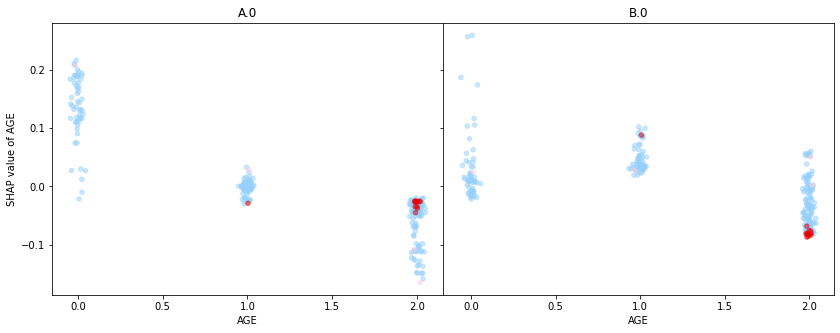

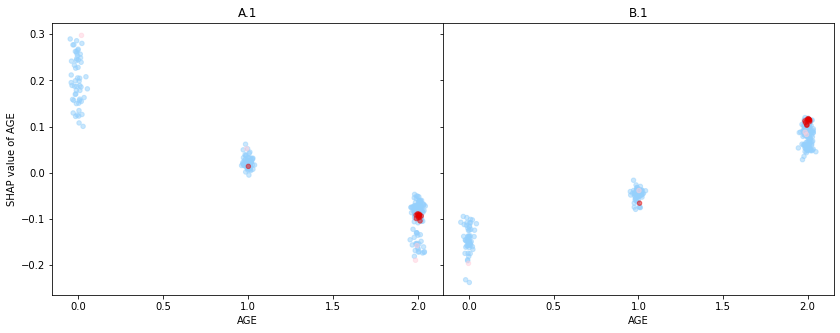

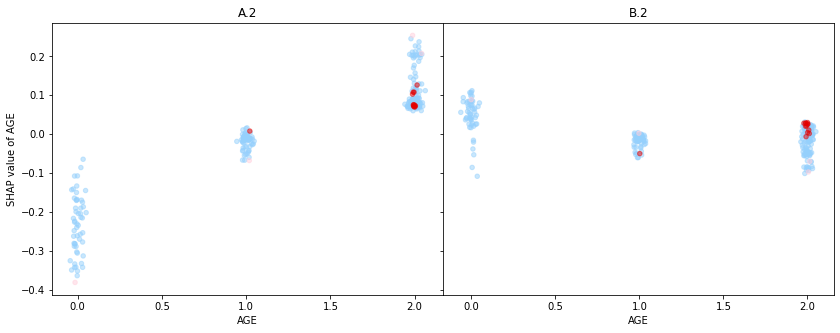

In [14]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('AGE', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

In [86]:
node = node.filter(X['AGE'] == 2)

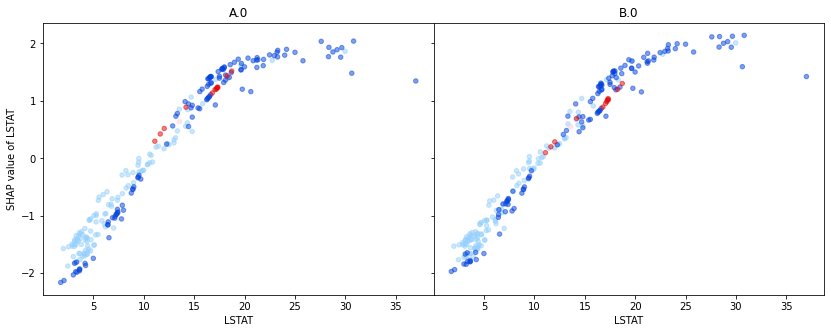

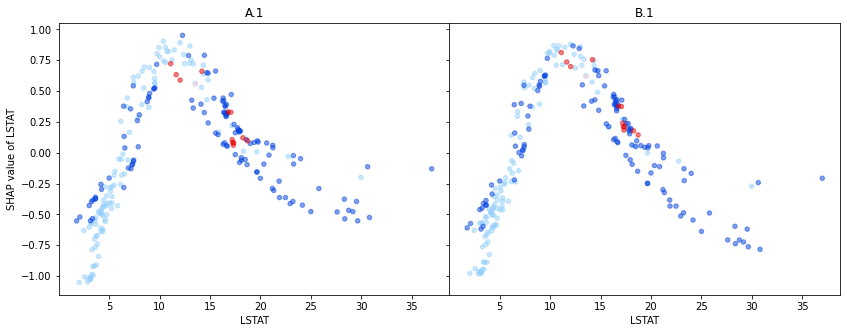

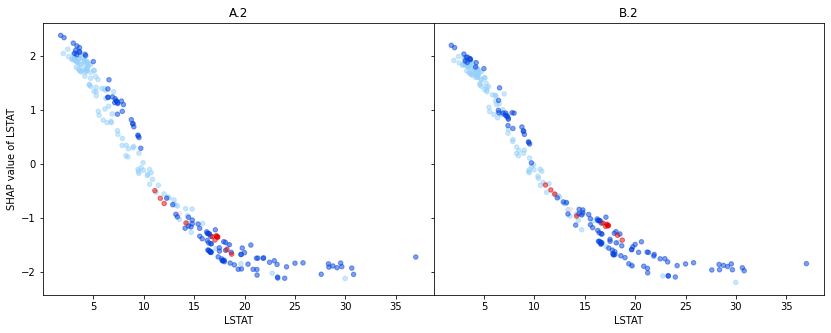

In [87]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.root.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, color=pred_label_names == '(0, 1)', focus=node)

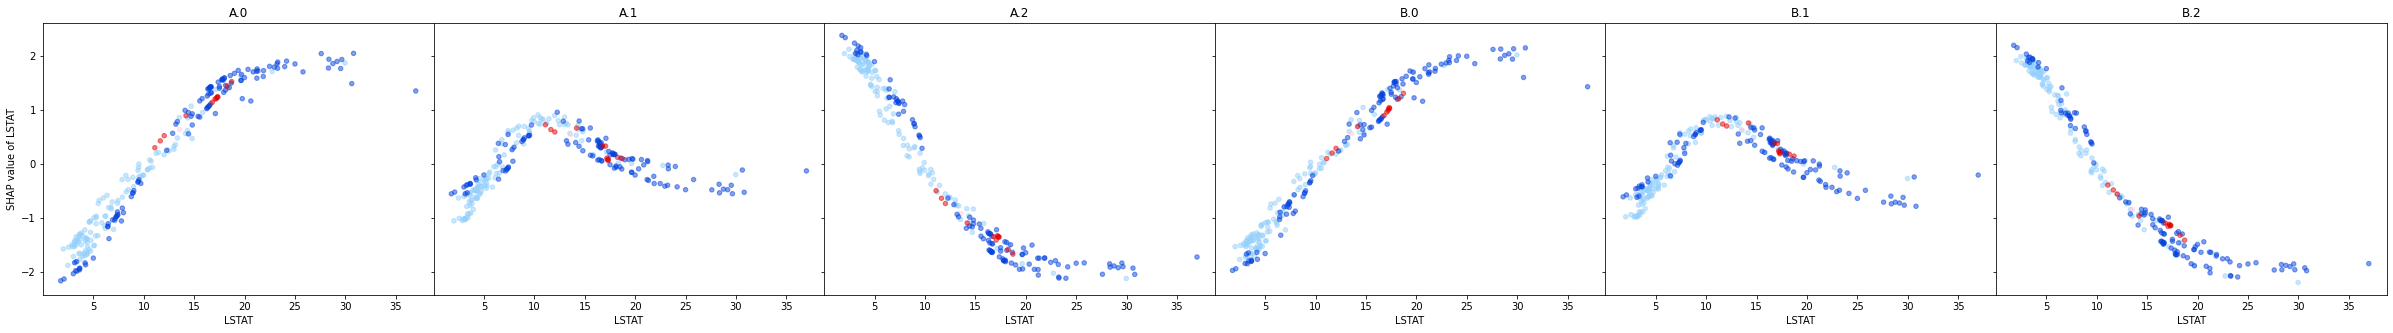

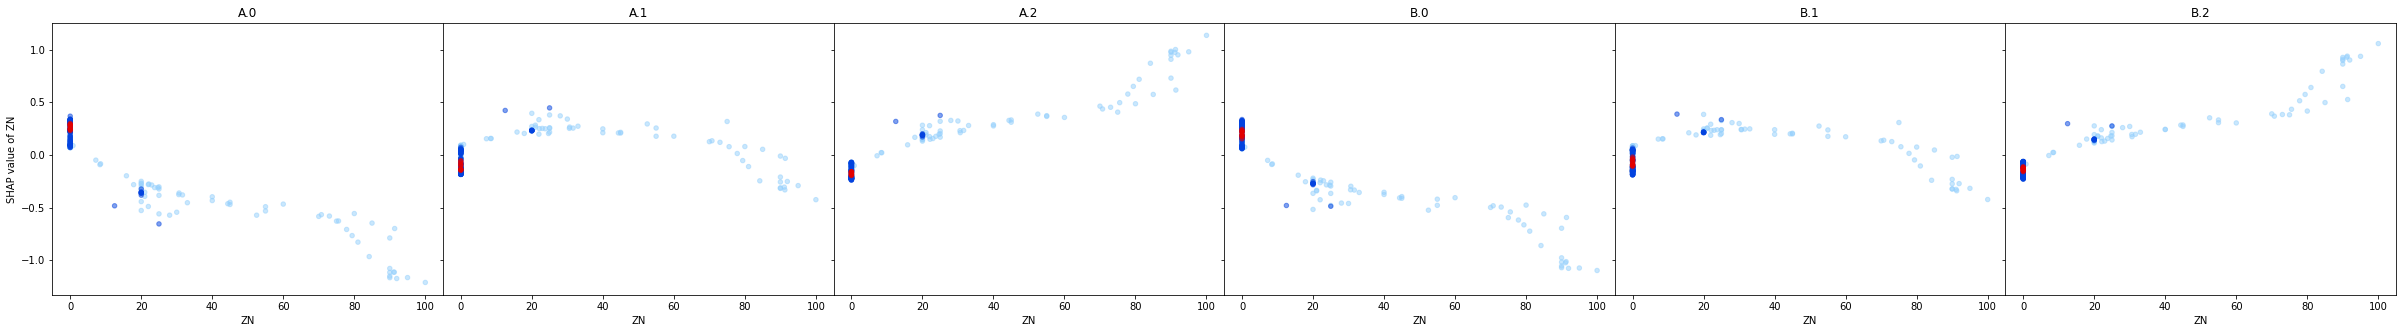

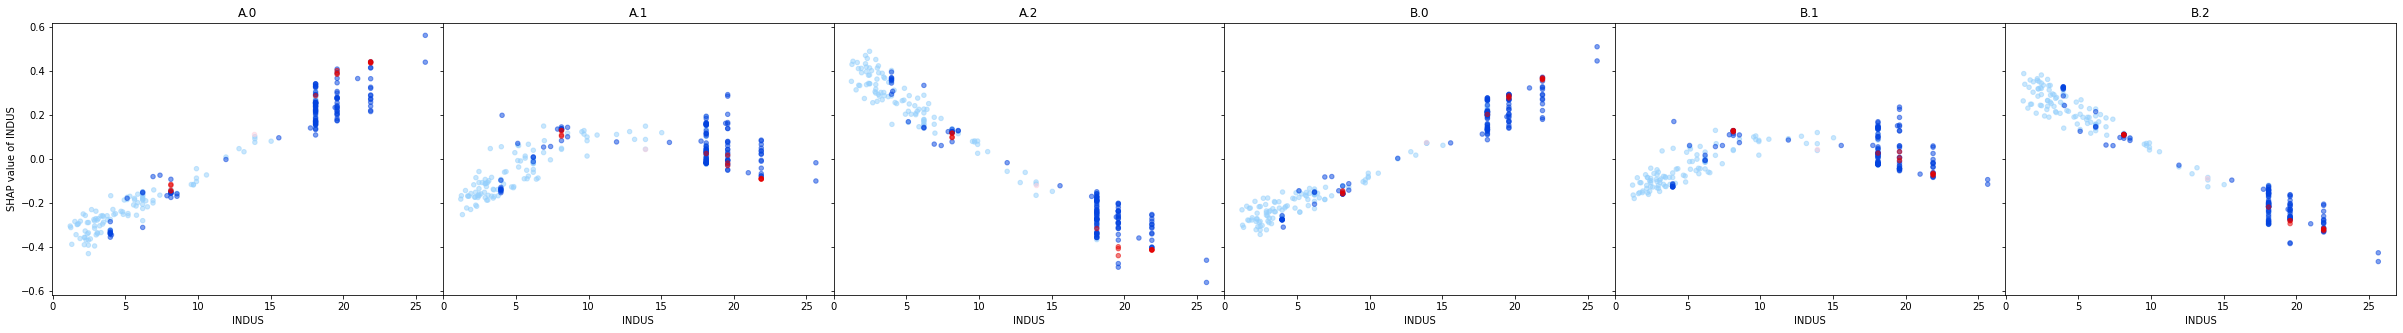

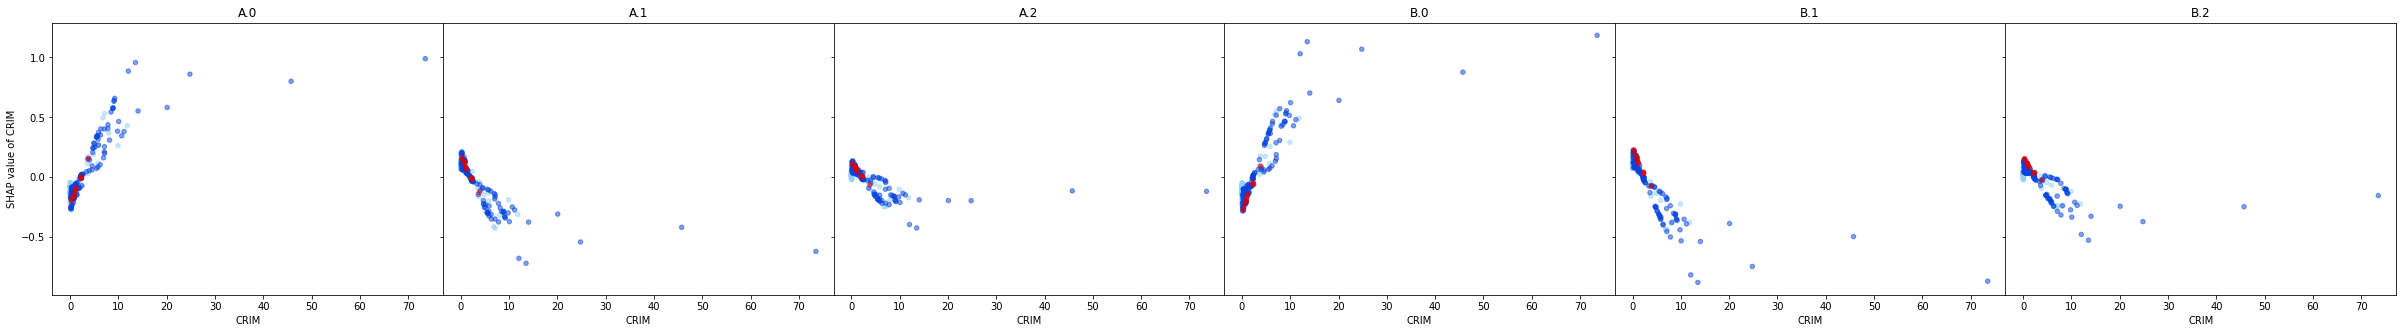

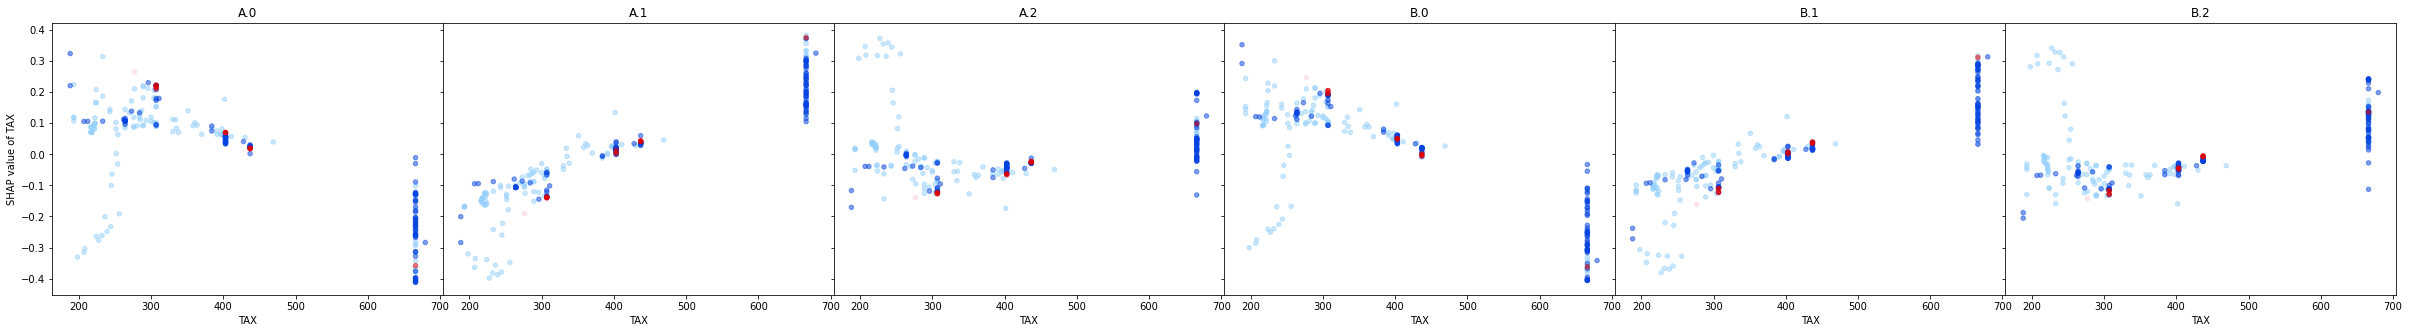

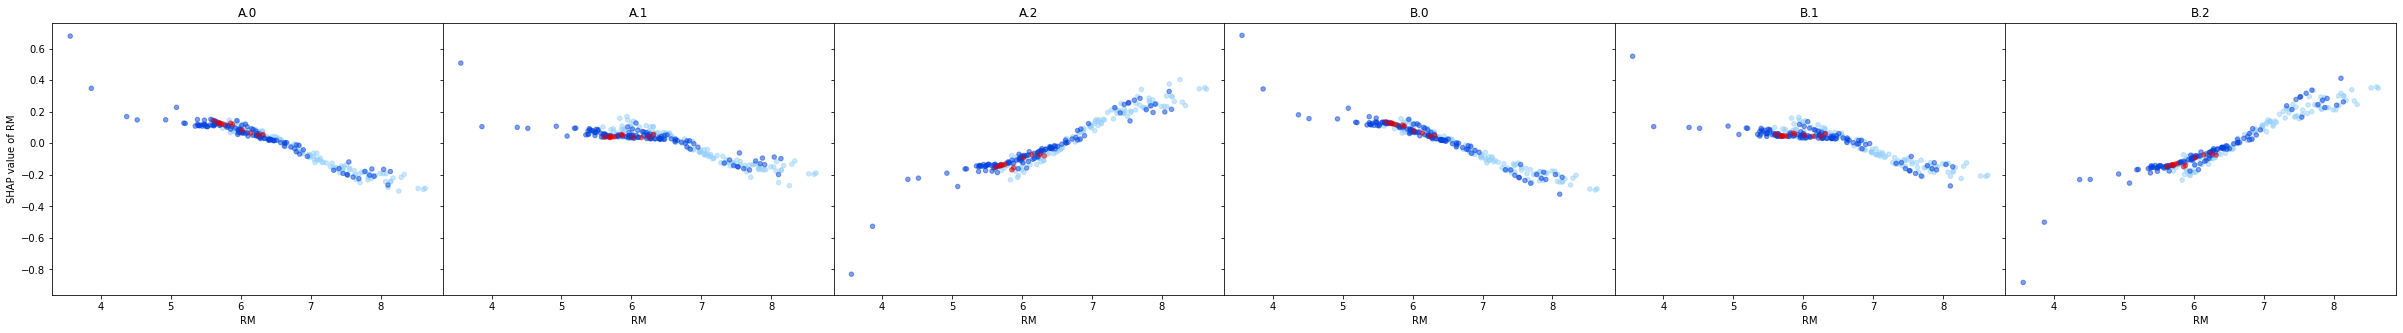

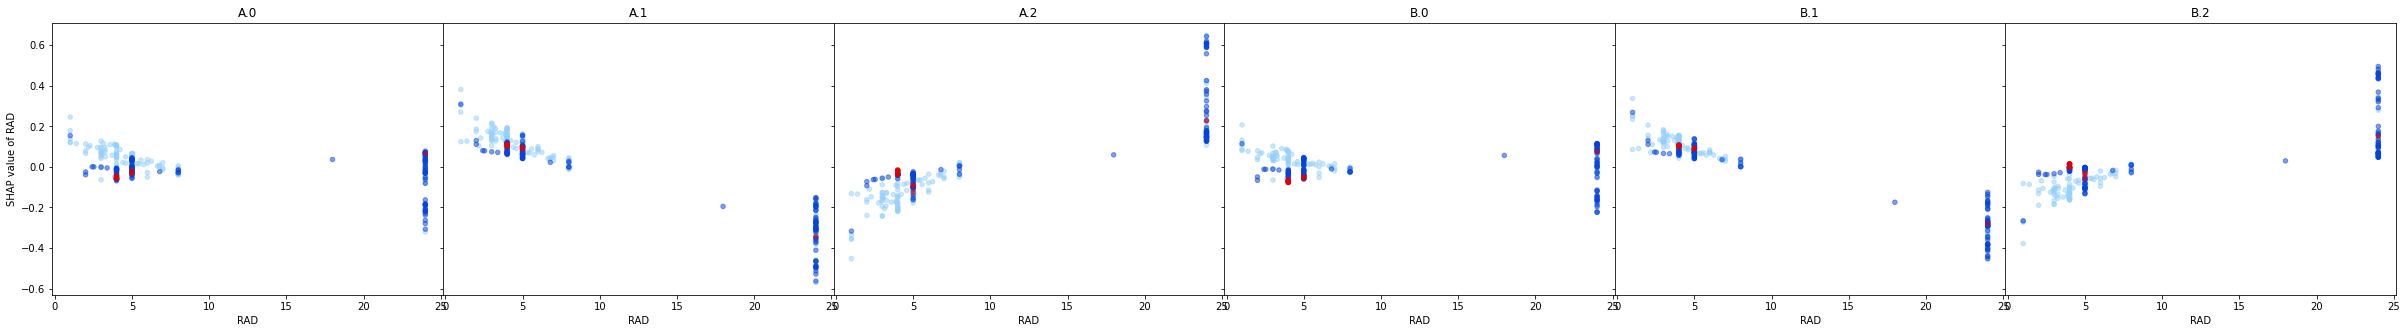

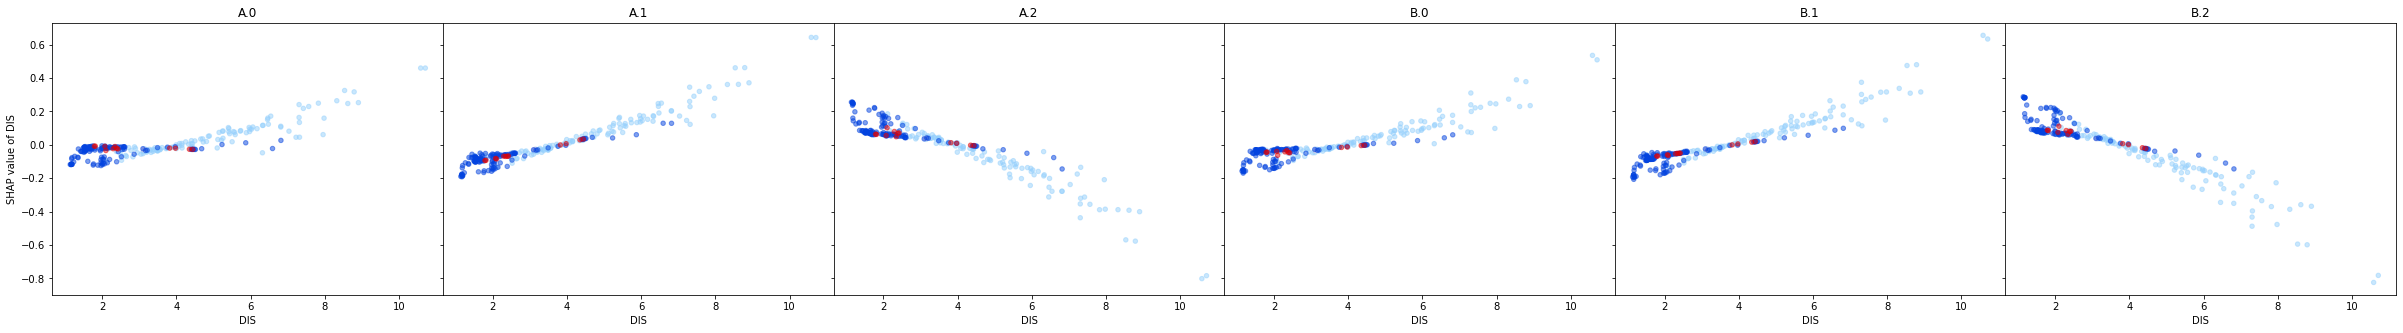

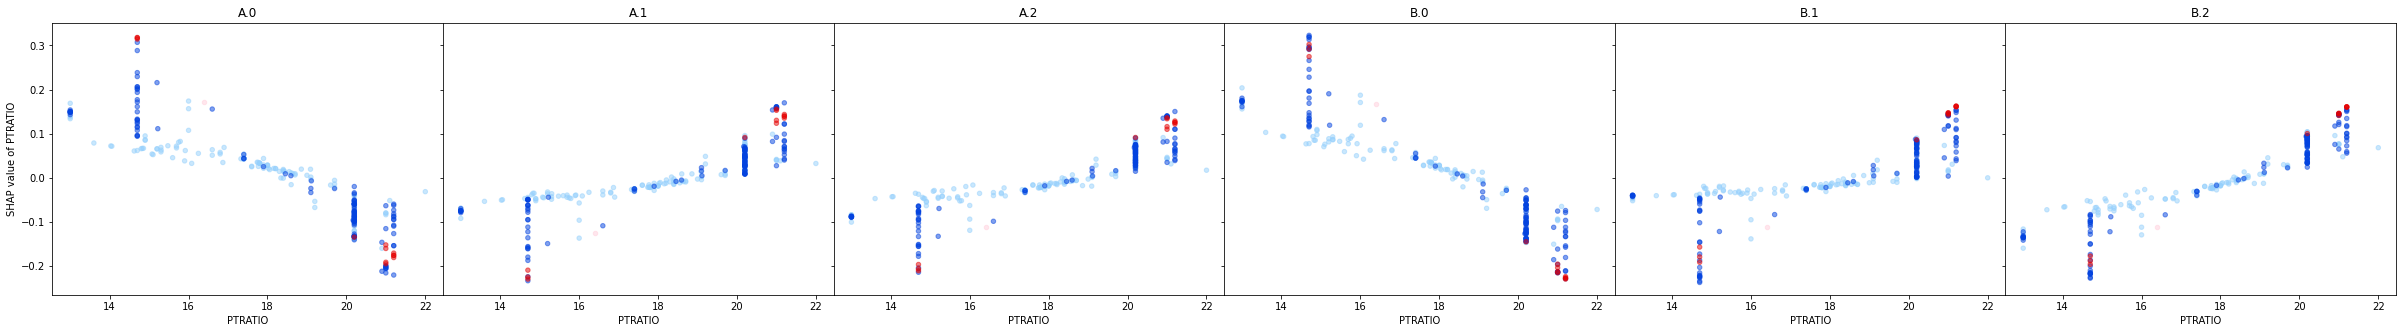

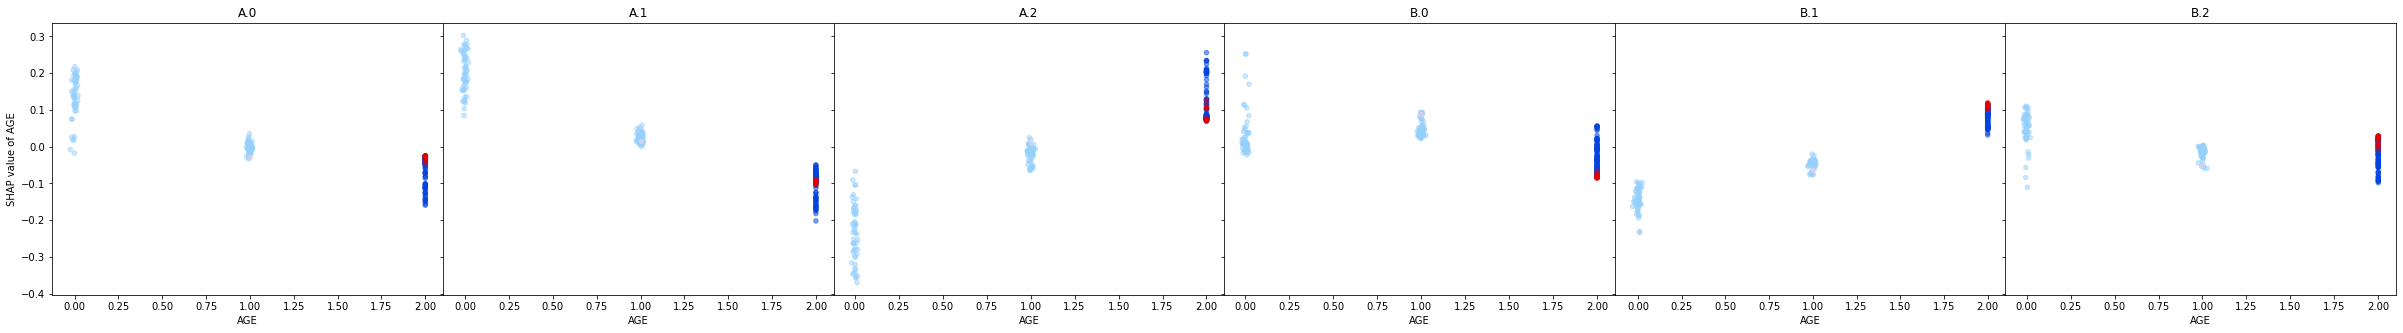

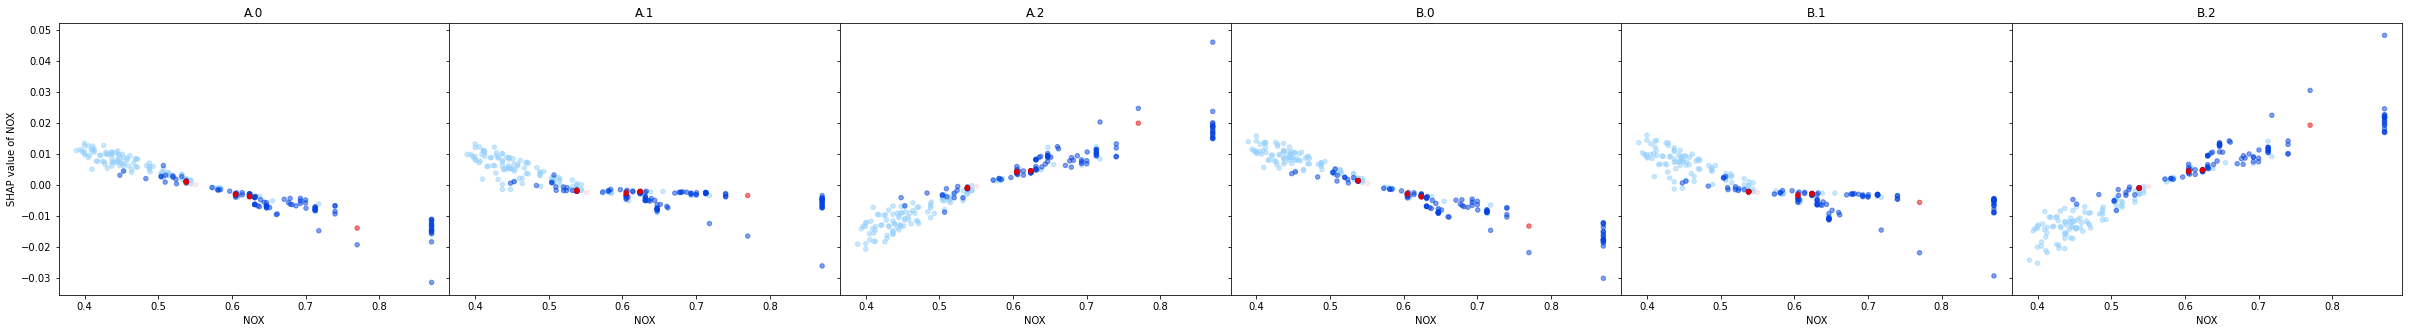

In [91]:
for feature in node.root.features_ordered:
    node.root.plot_feature_dependence(feature, alpha=0.5, color=pred_label_names == '(0, 1)', focus=node)

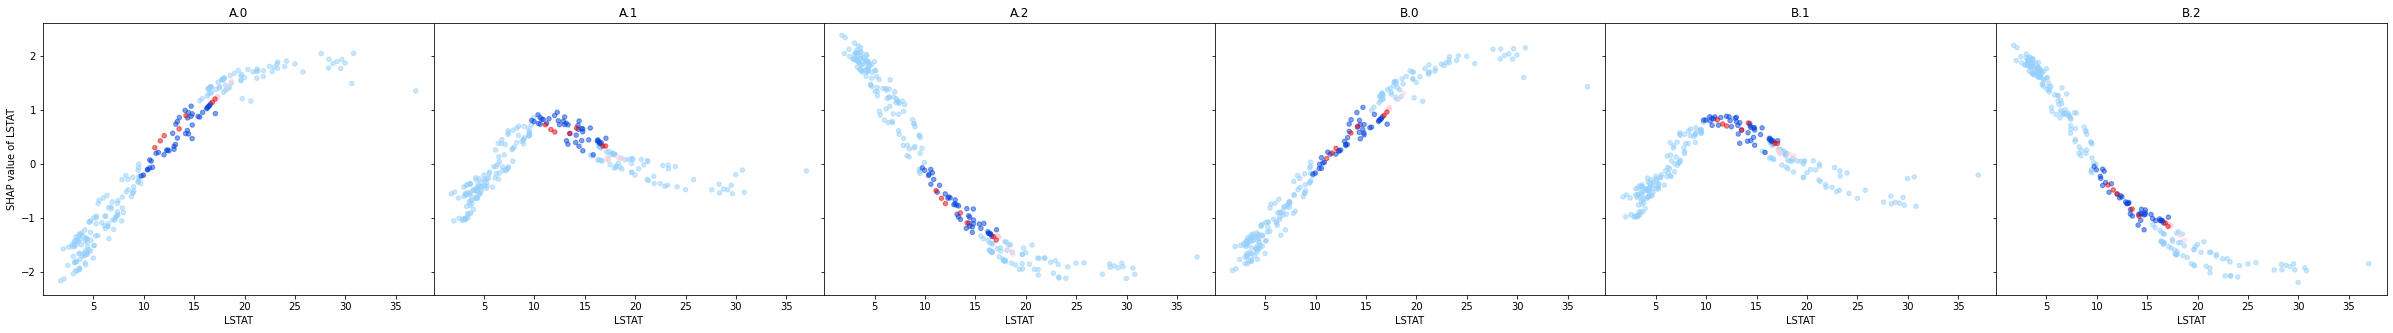

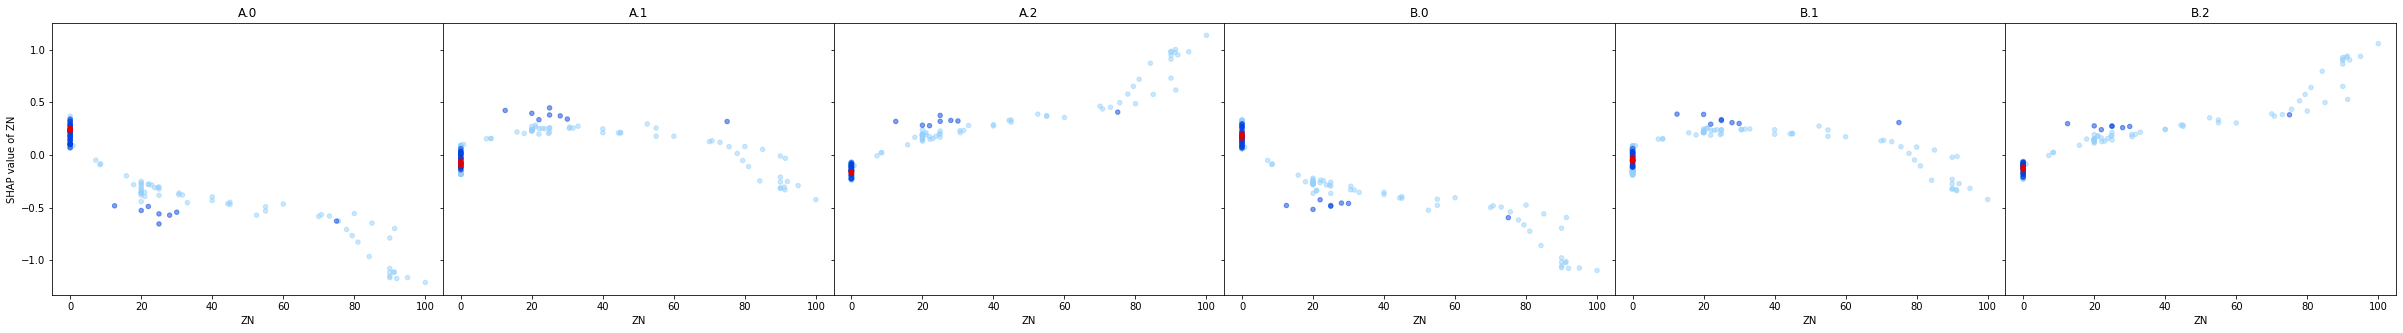

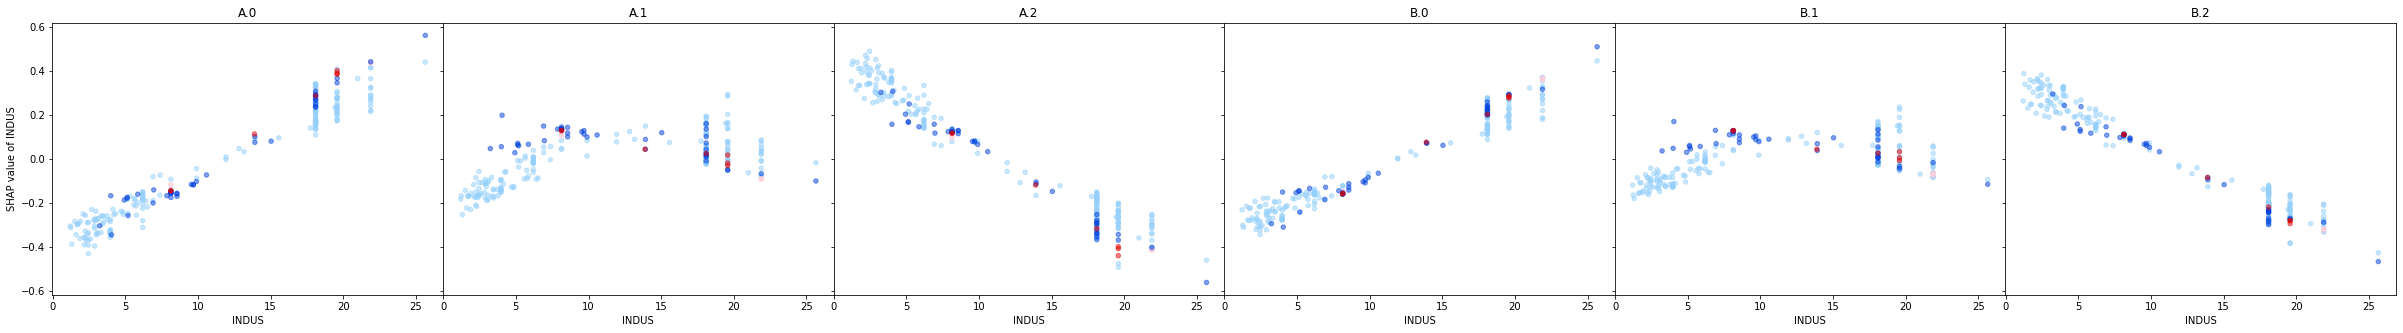

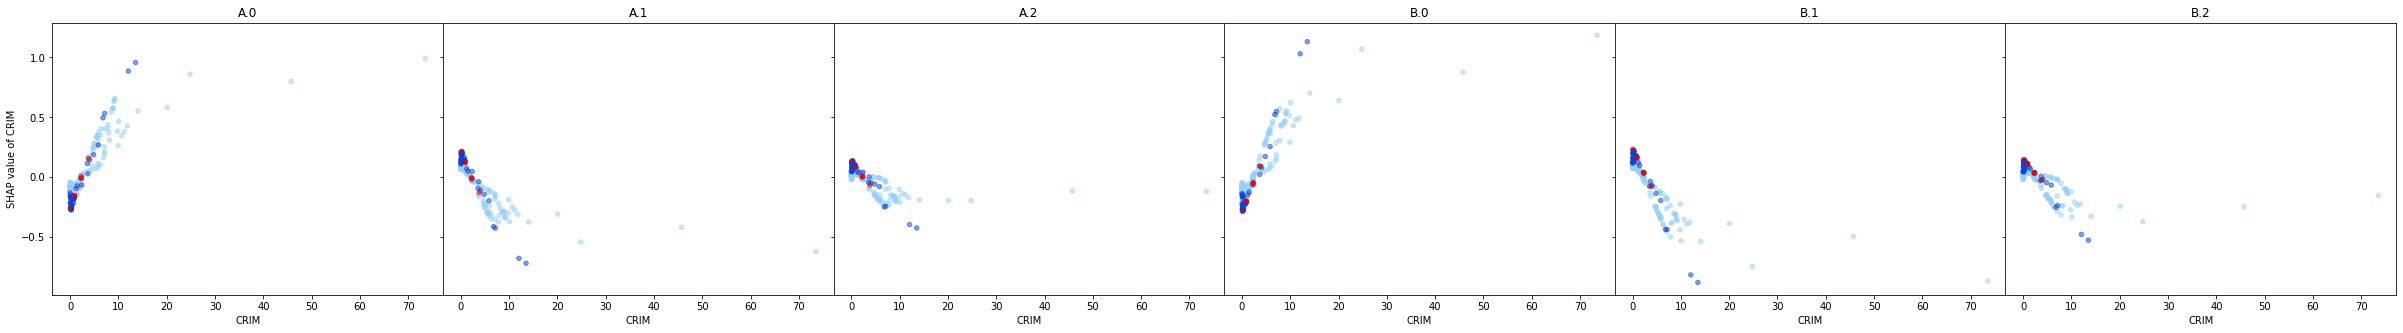

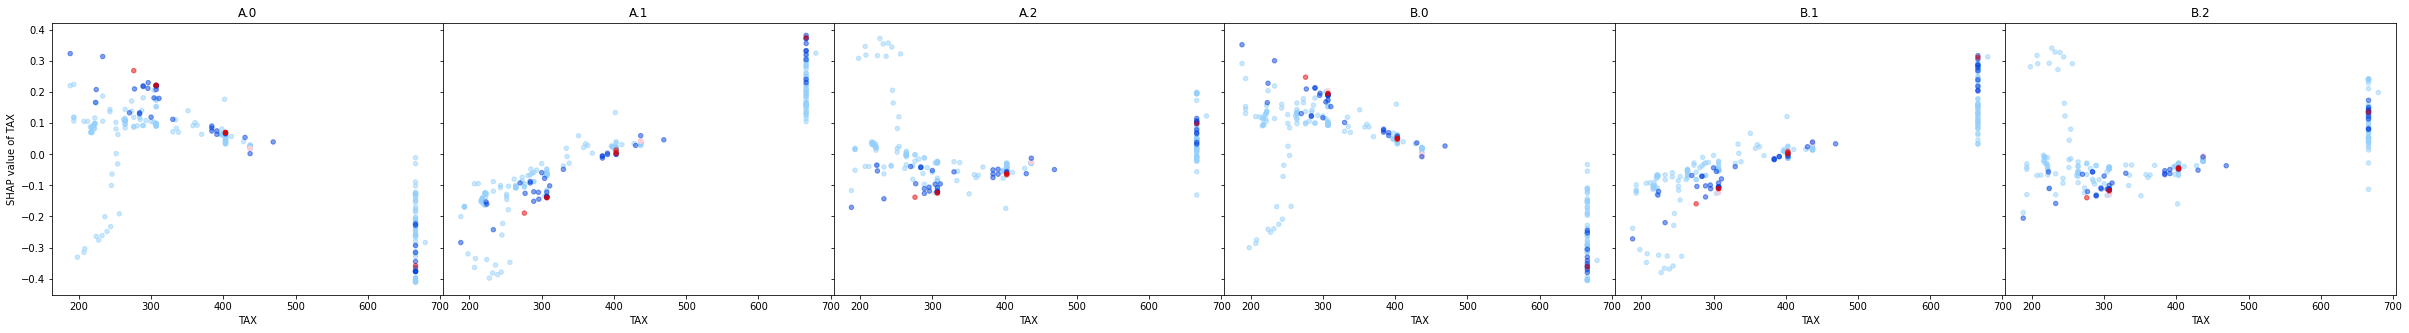

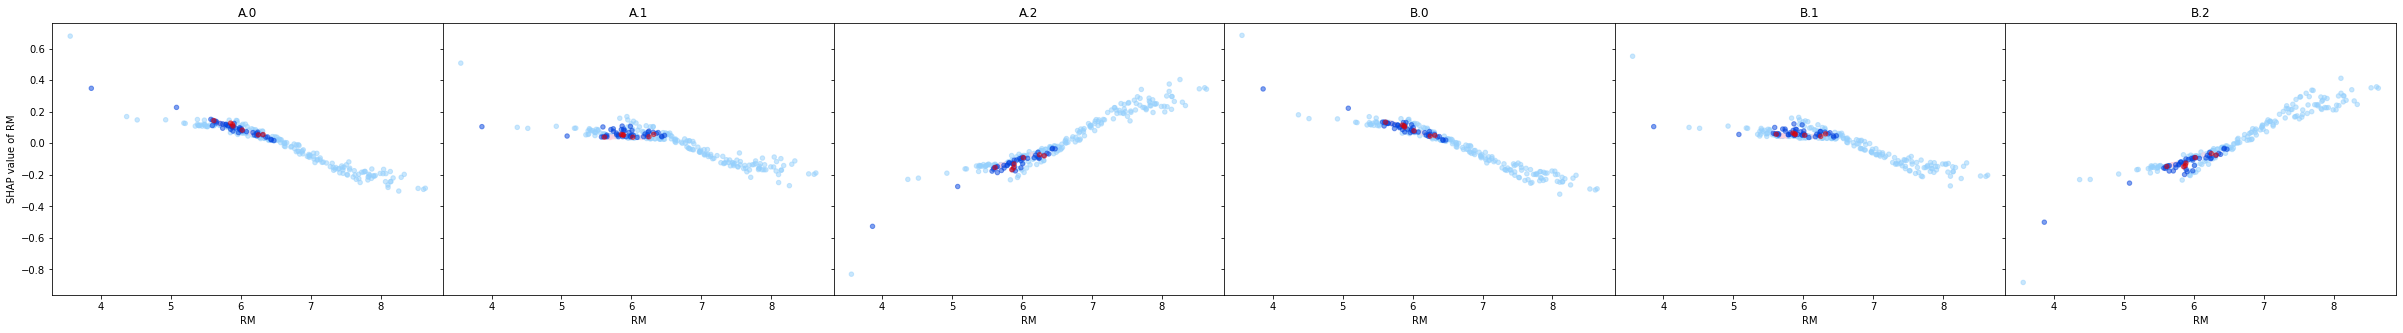

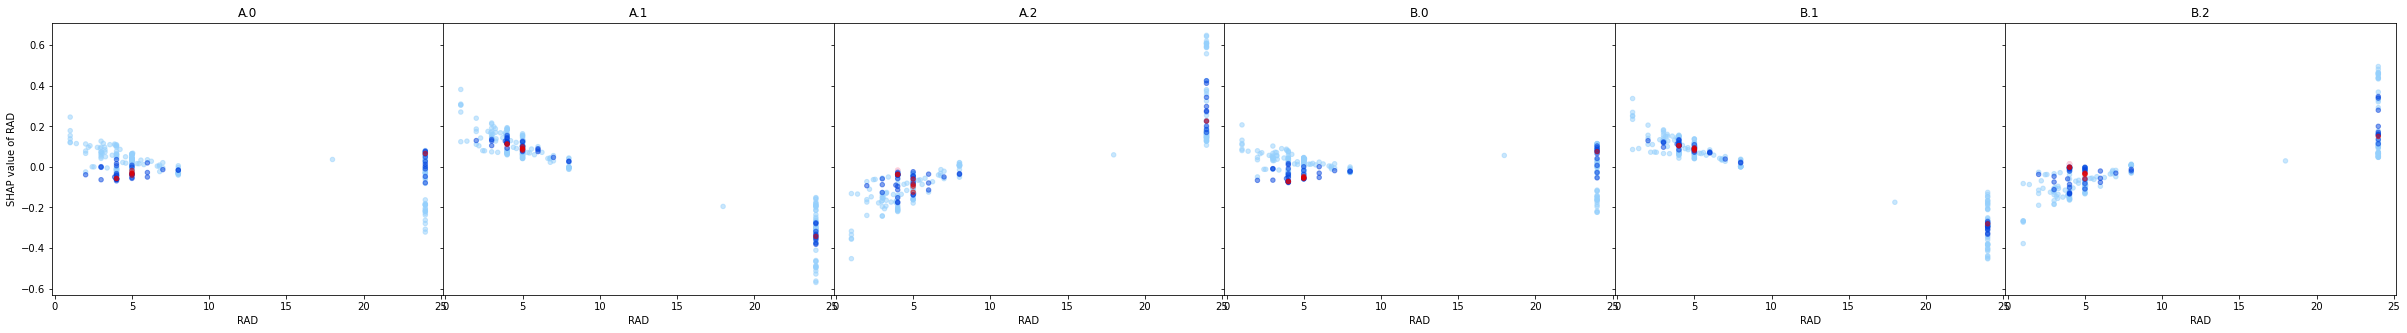

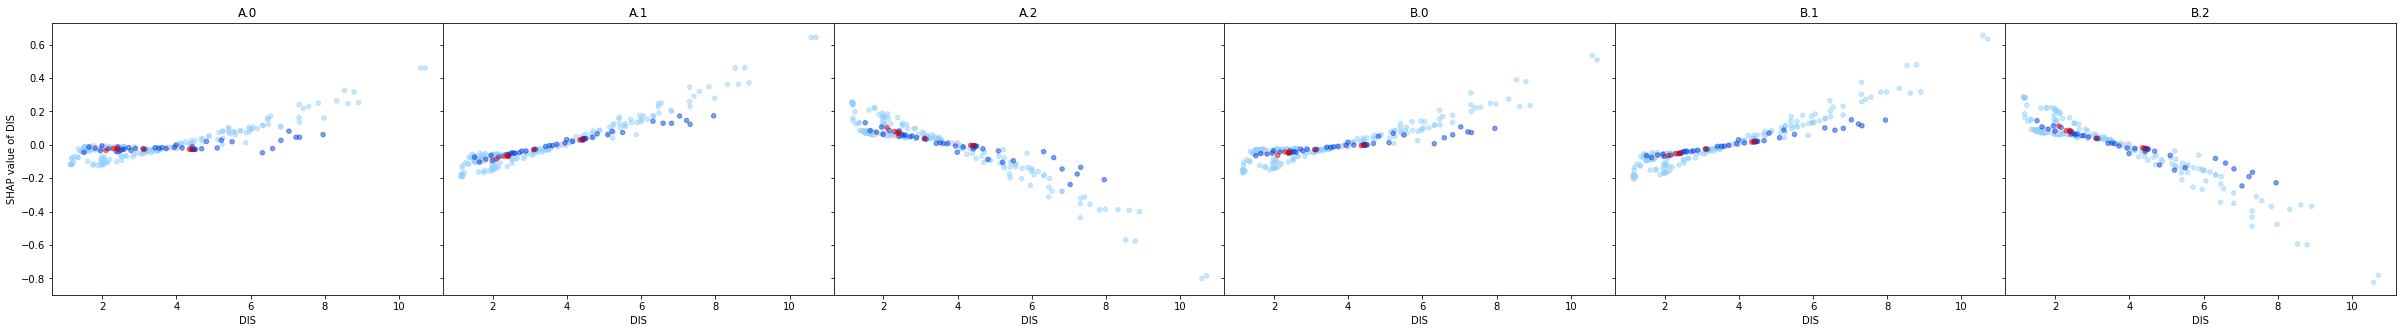

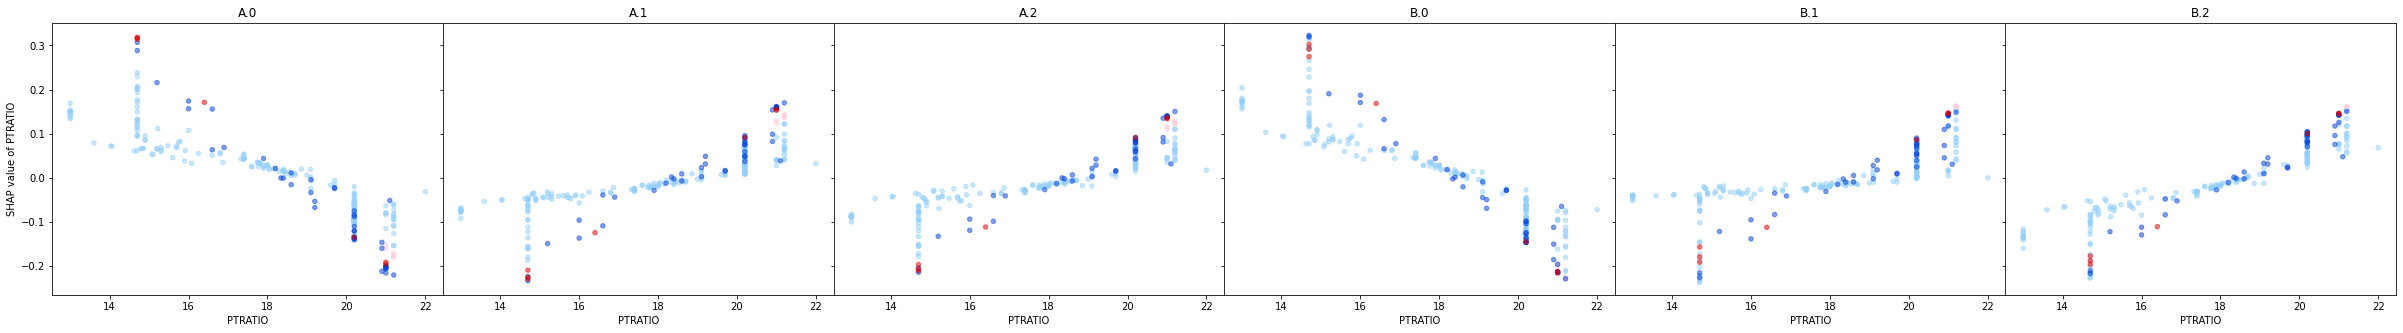

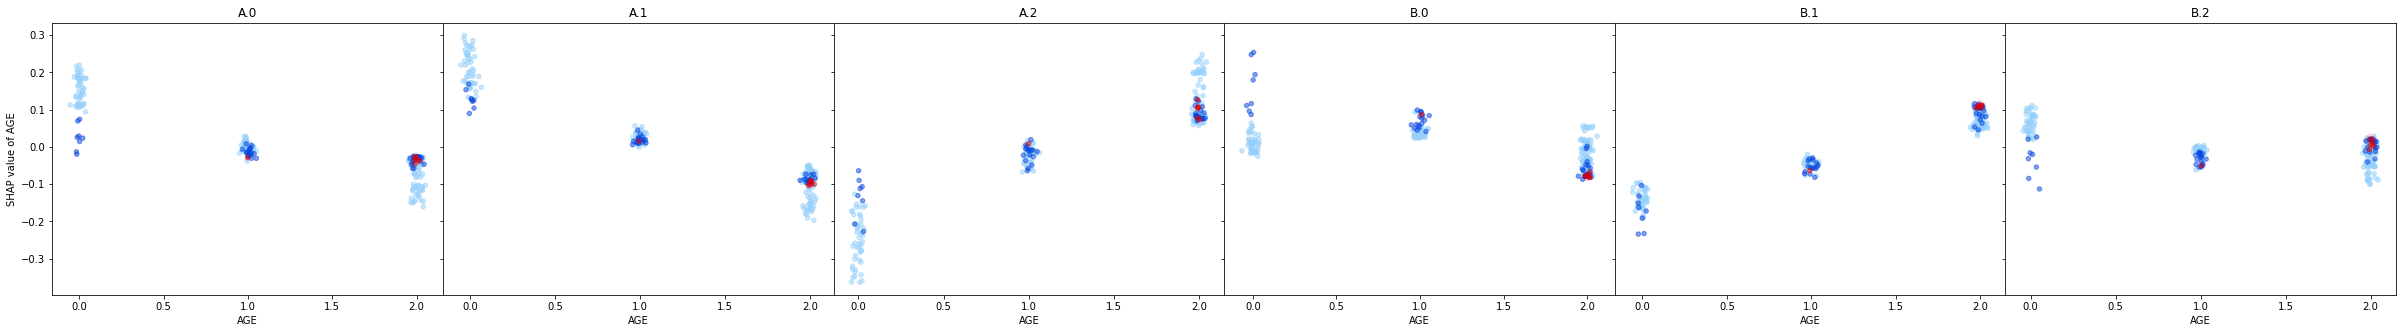

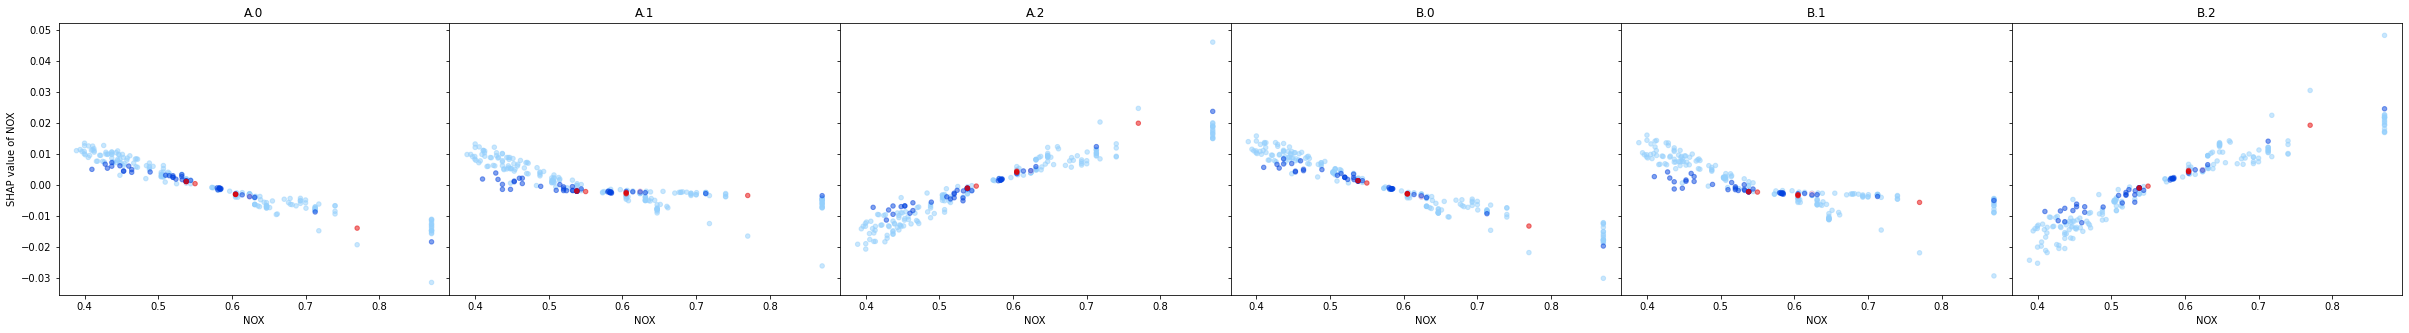

In [123]:
for feature in node.root.features_ordered:
    node.root.plot_feature_dependence(feature, alpha=0.5, color=pred_label_names == '(0, 1)', focus=node.root.get('LR'))

In [125]:
node = node.root.filter(pred_label_names == '(0, 1)')

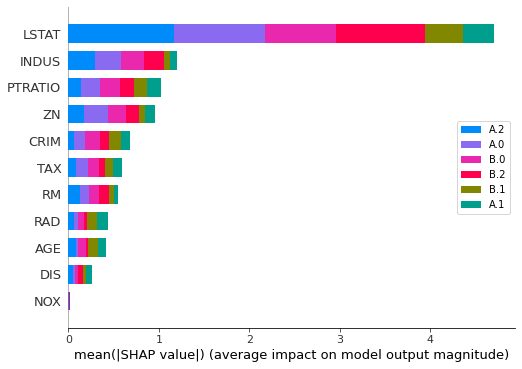

In [126]:
plot_feature_importance_bar(node.shap_values)

#### (1,2)

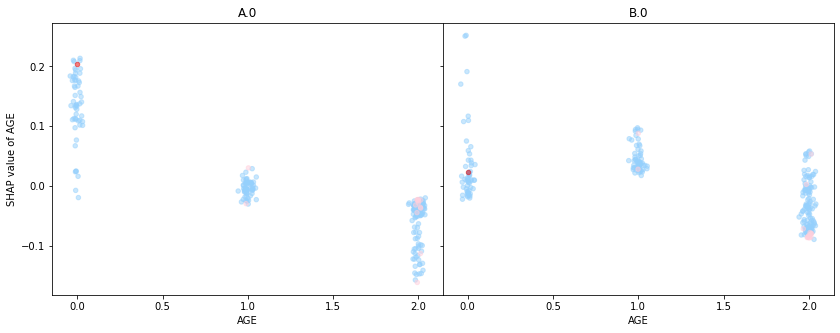

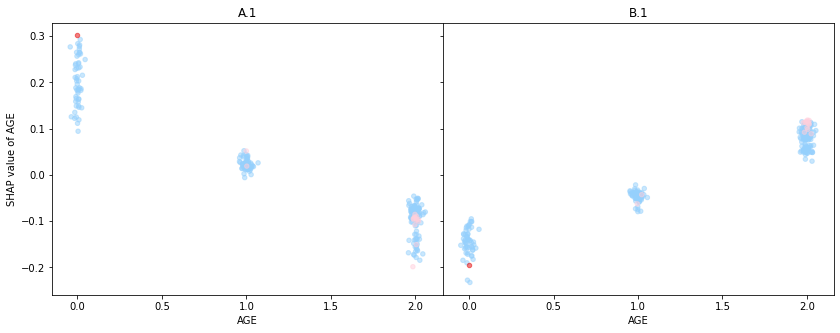

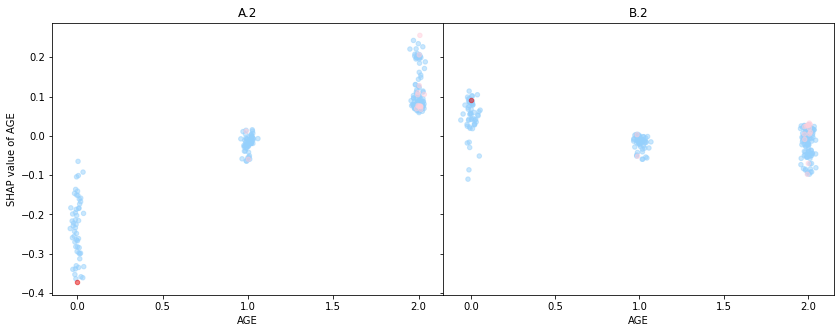

In [16]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('AGE', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

### (2,1)

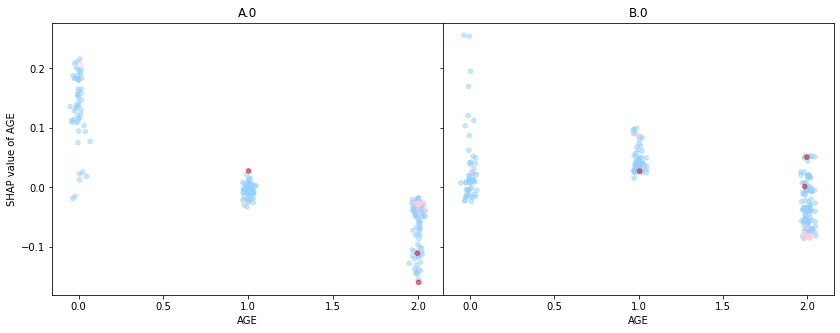

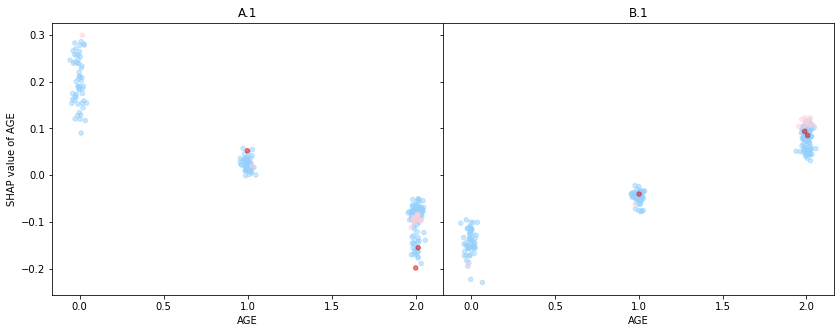

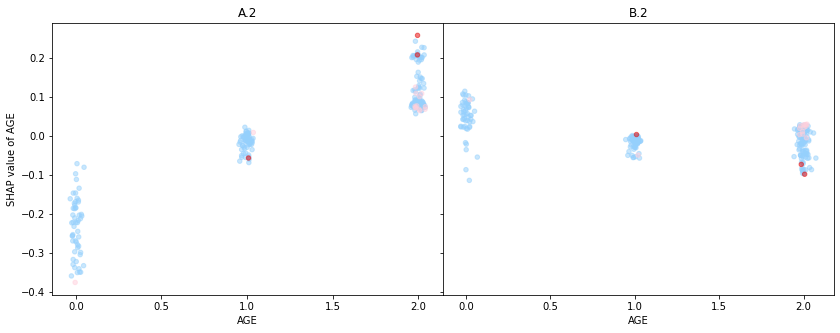

In [17]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('AGE', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

Nothing obviously different

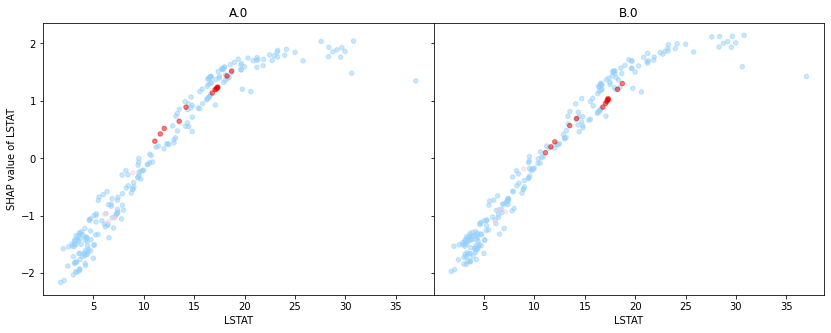

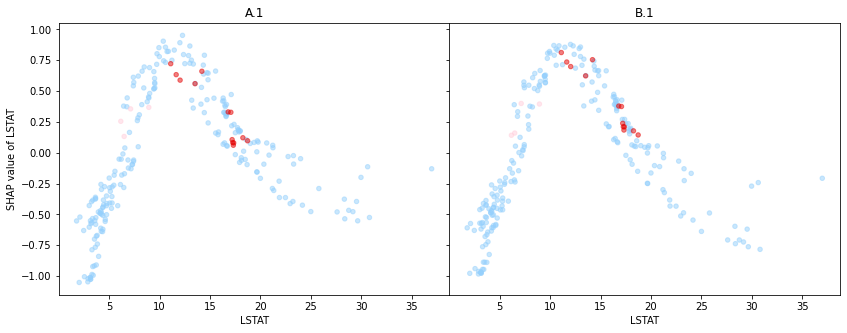

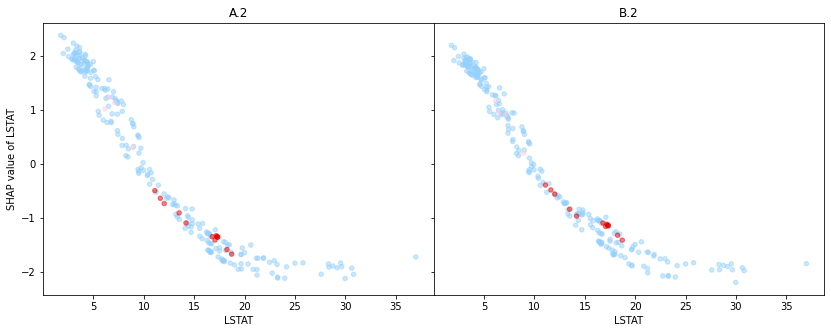

In [15]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

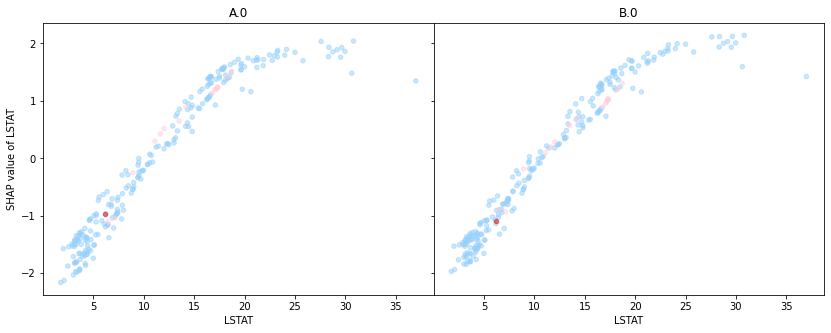

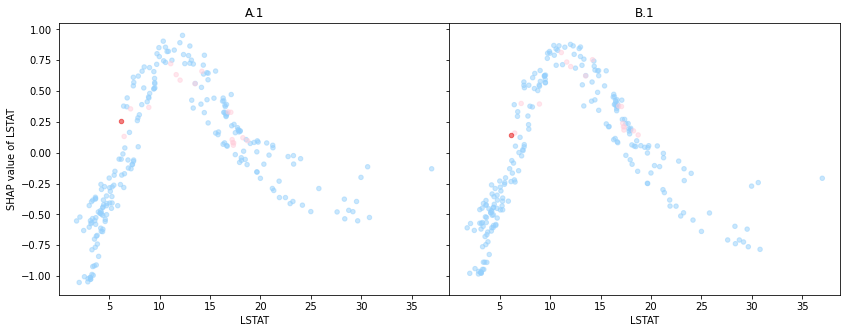

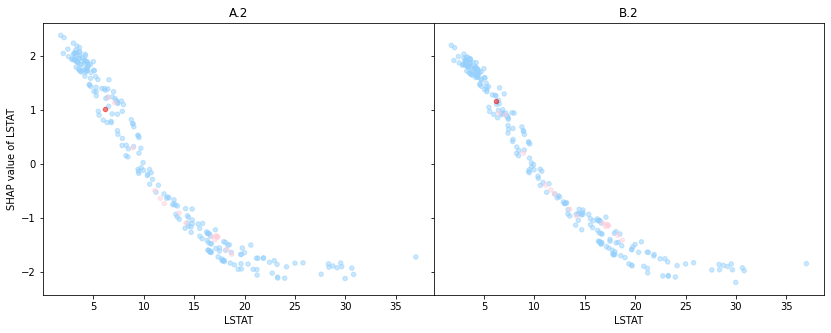

In [18]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

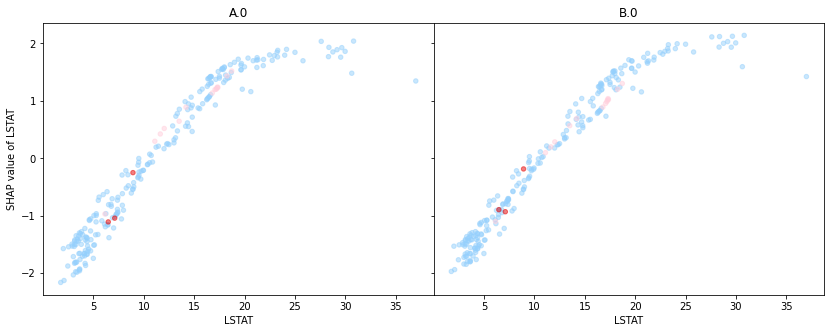

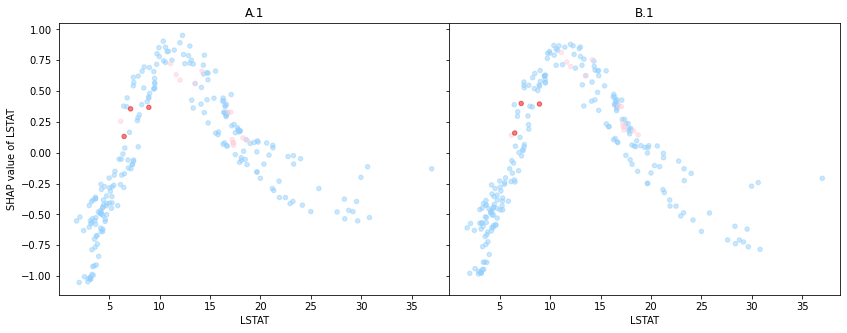

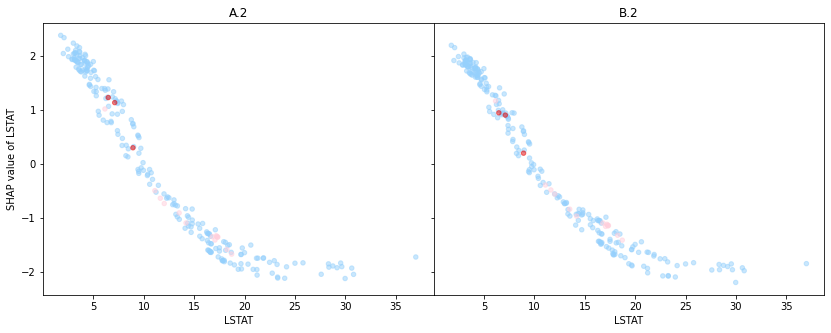

In [19]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

### A vs. C

In [20]:
node = make_clustering(comparer_ac, indiv_shap_values_ac, categorical_features=categorical_features)

In [25]:
pred_labels = comparer_ac.predict_mclass_diff(node.data)
pred_label_names = comparer_ac.class_names[pred_labels]

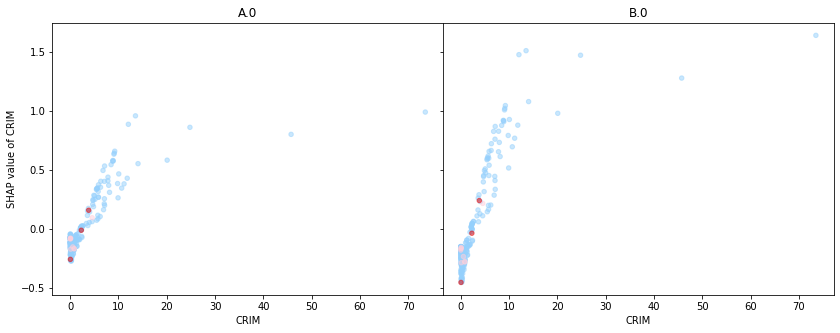

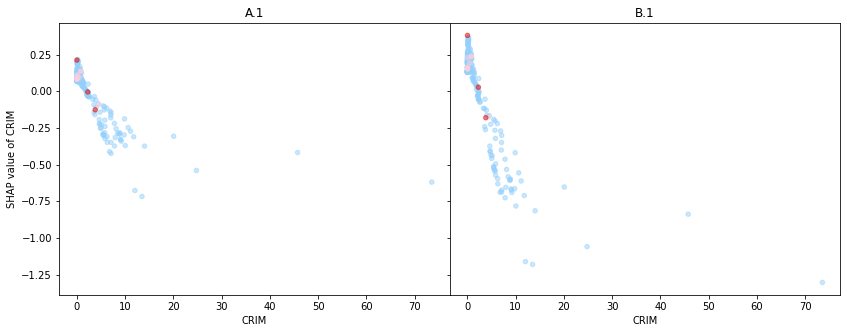

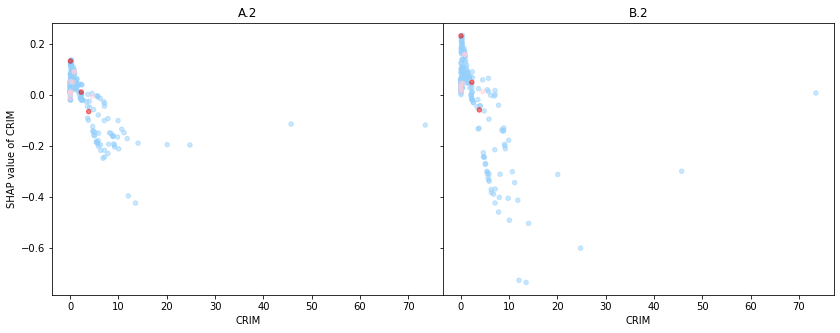

In [26]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('CRIM', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

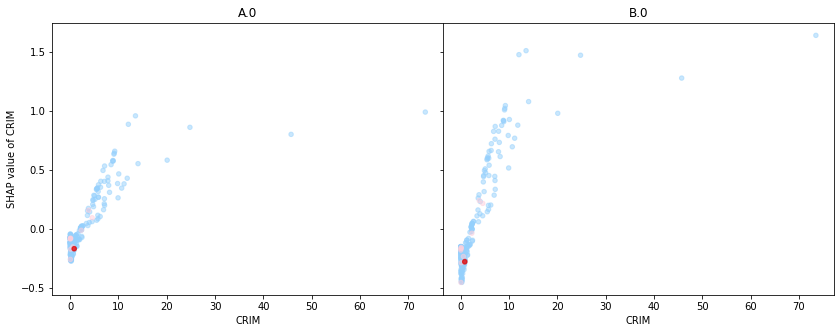

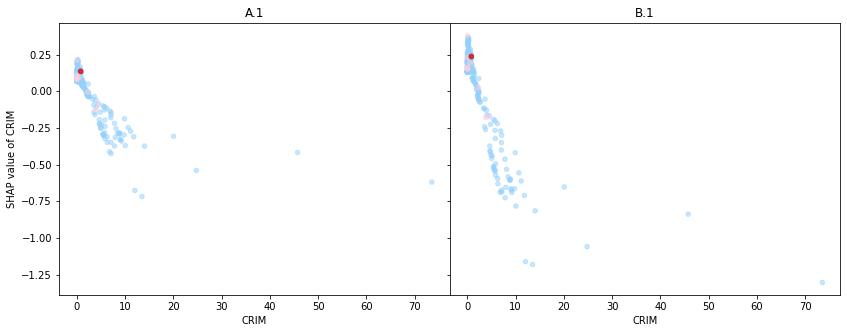

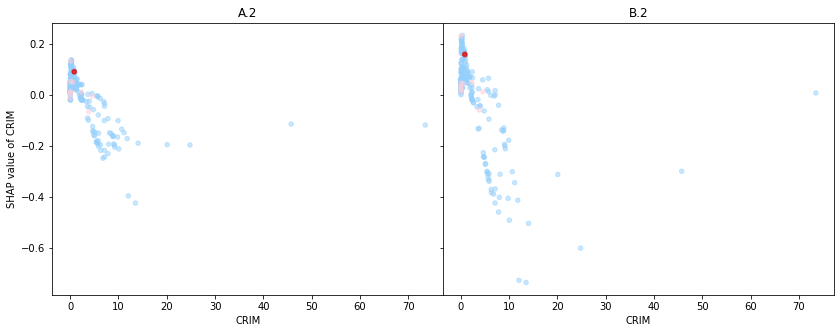

In [27]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('CRIM', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 0)')

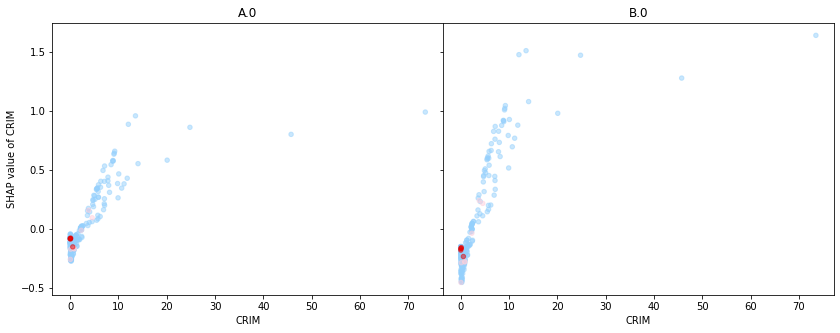

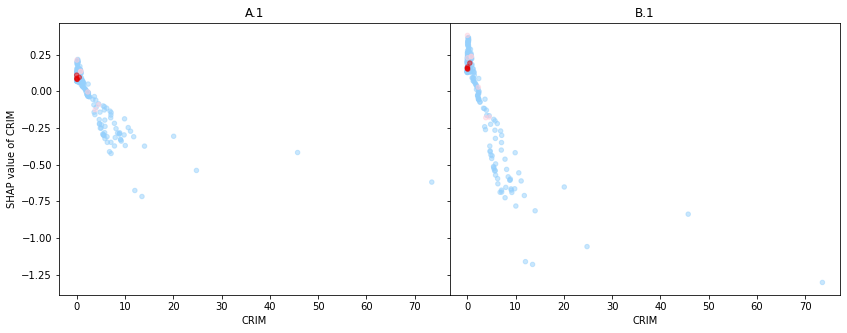

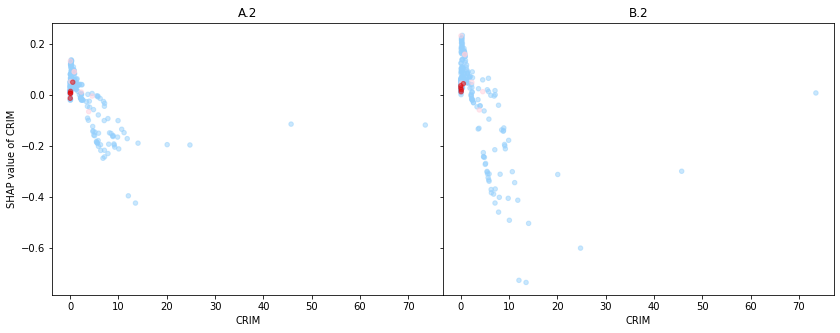

In [28]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('CRIM', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

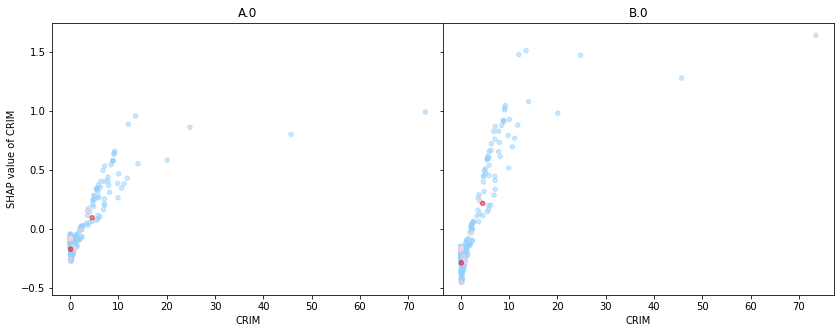

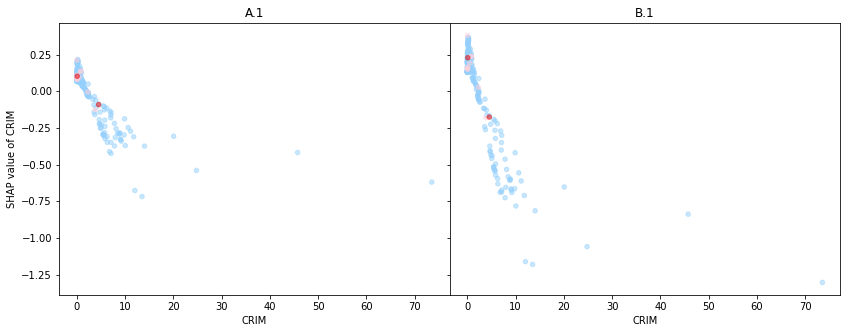

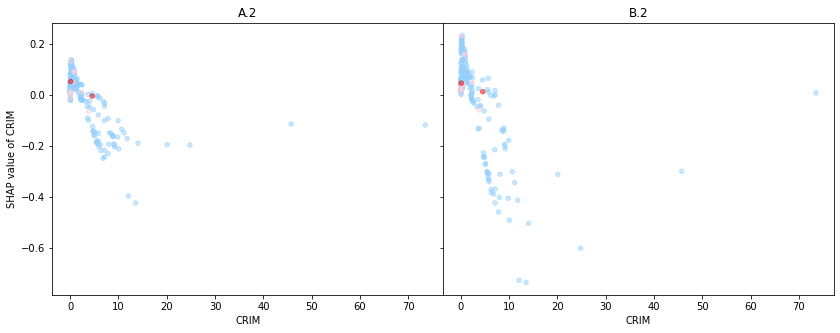

In [29]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('CRIM', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

Tail to the right (> 20) with different slope, especially visible for label 0

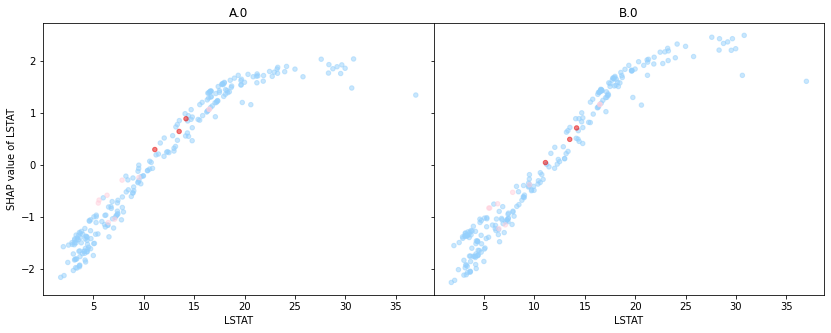

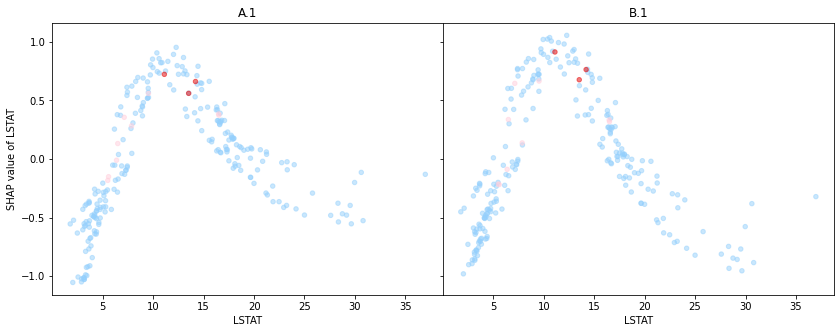

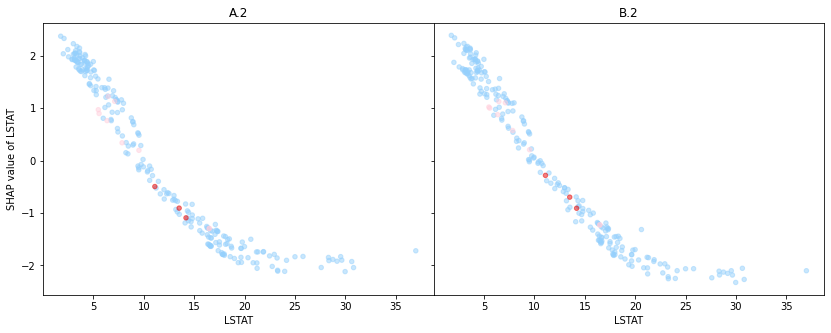

In [30]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

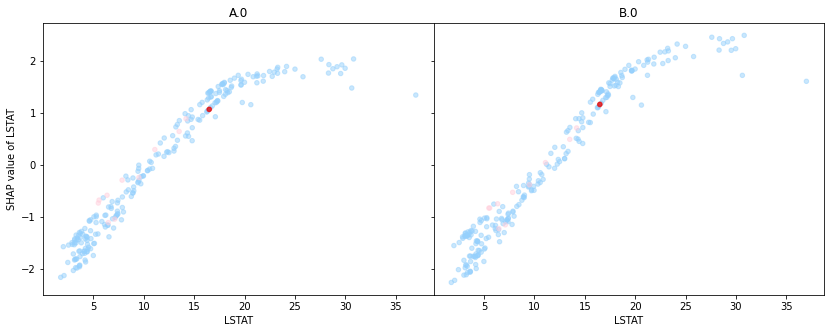

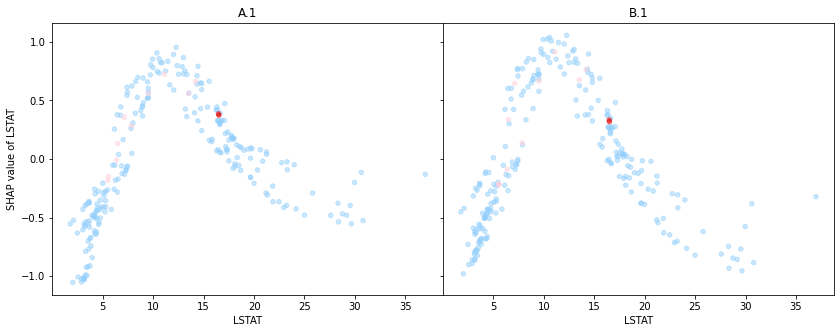

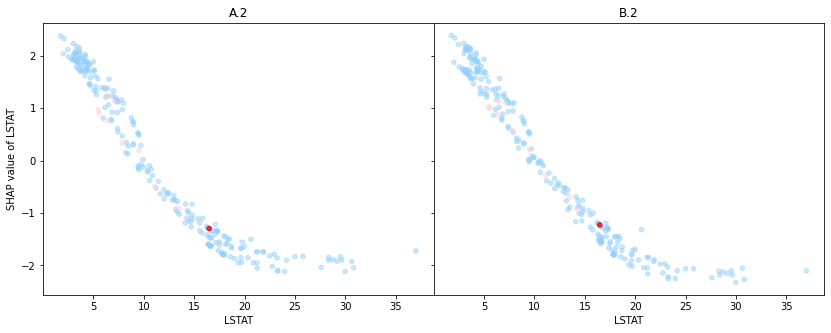

In [31]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 0)')

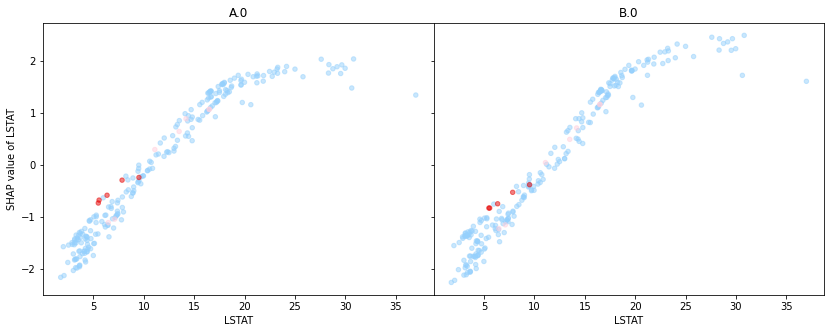

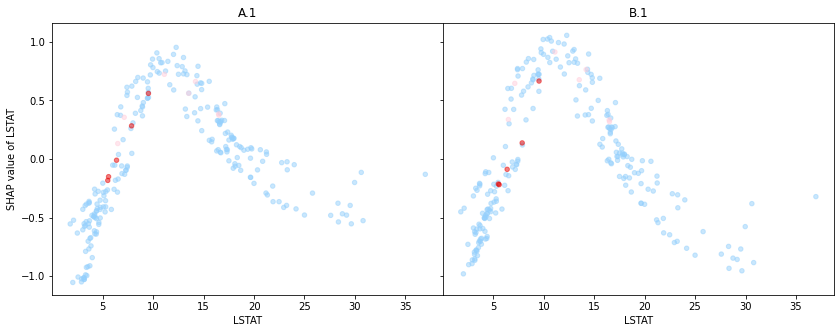

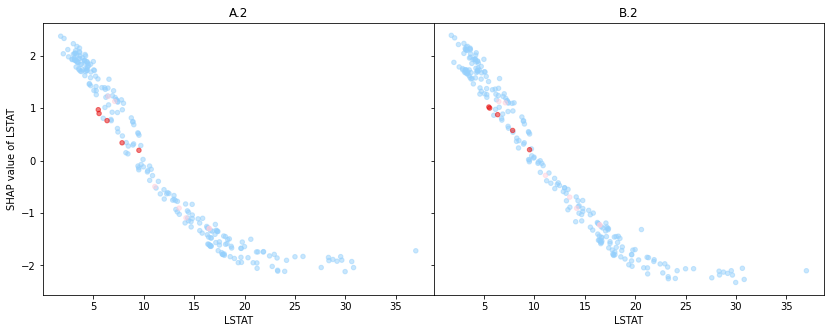

In [32]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

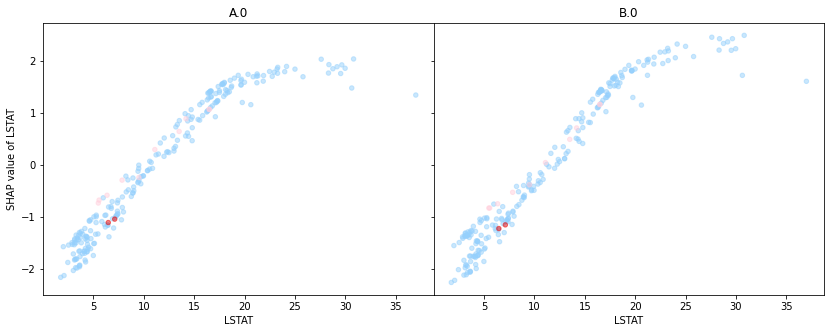

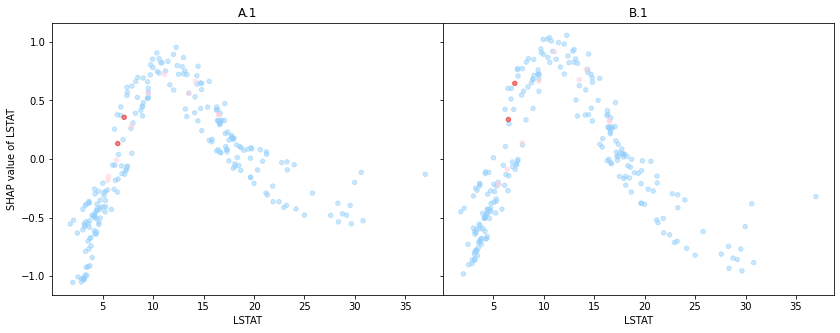

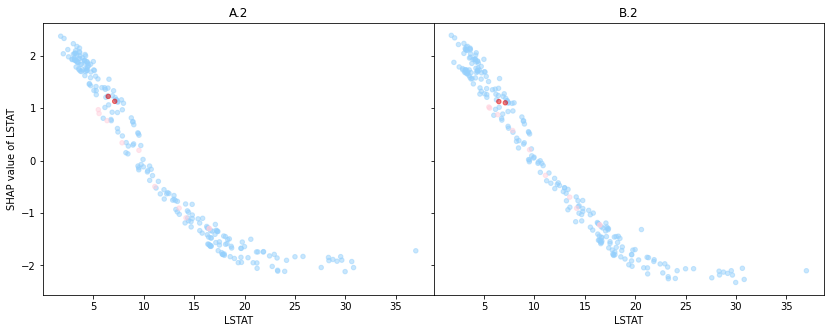

In [33]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('LSTAT', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

Different slopes present

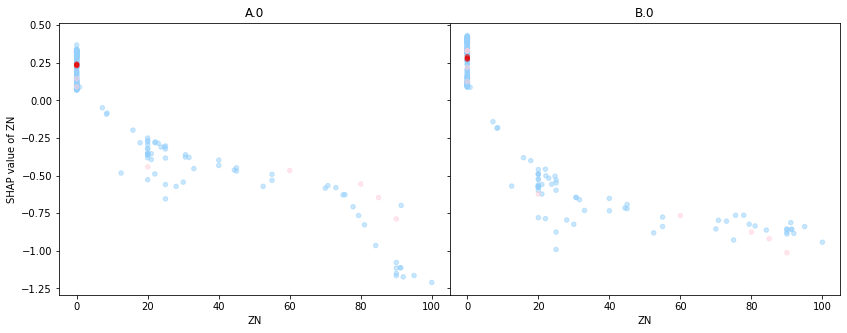

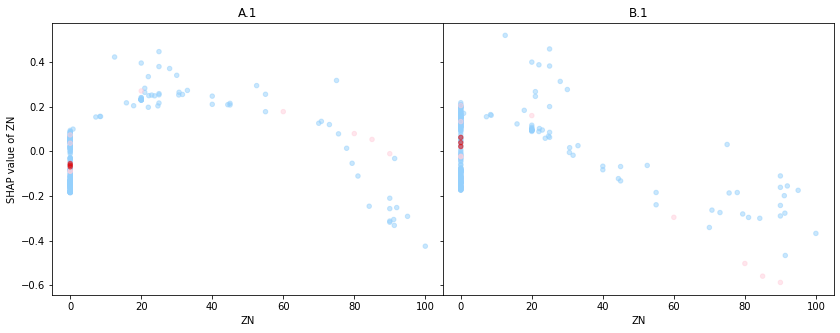

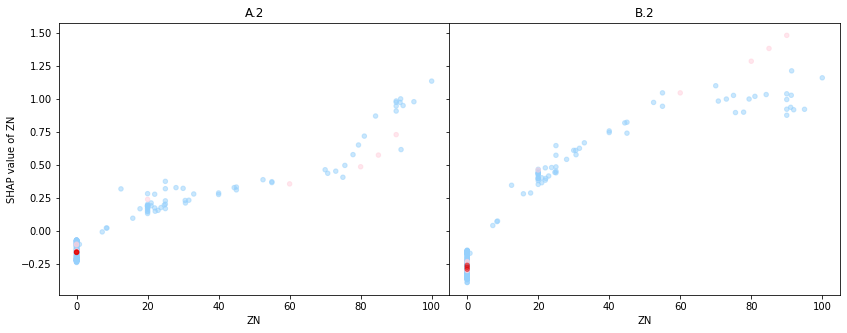

In [34]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('ZN', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

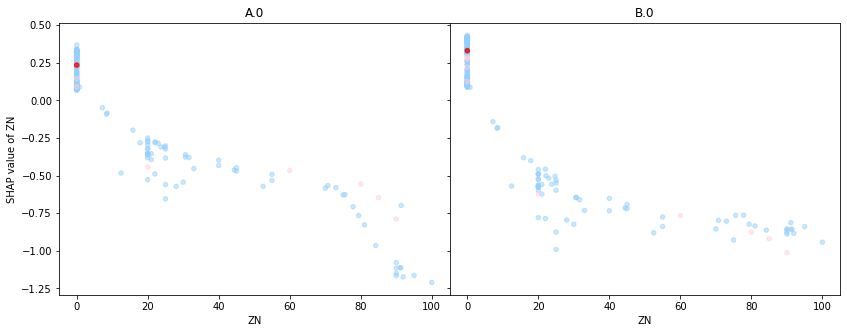

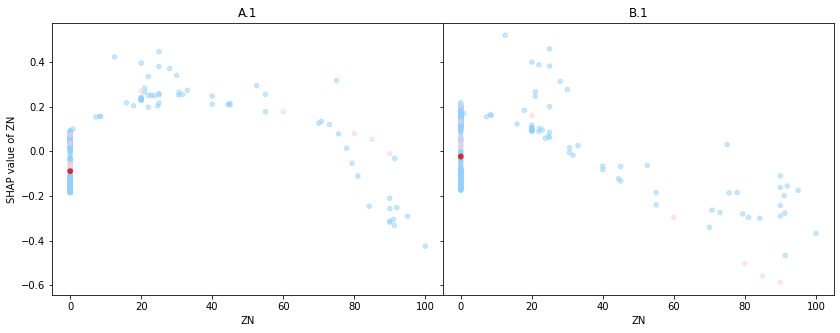

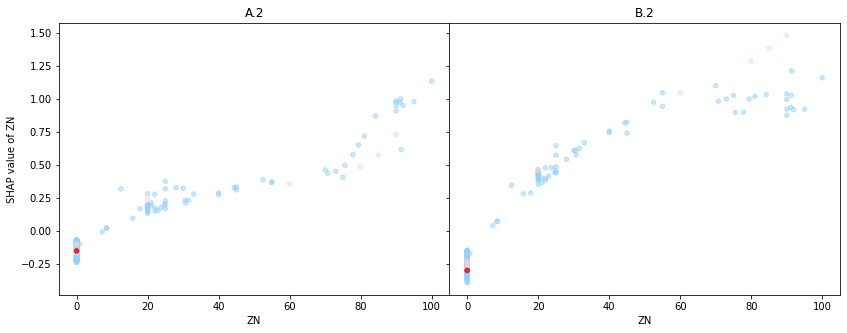

In [35]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('ZN', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 0)')

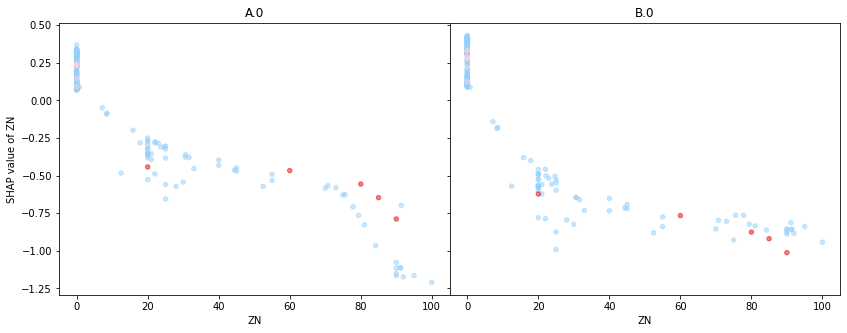

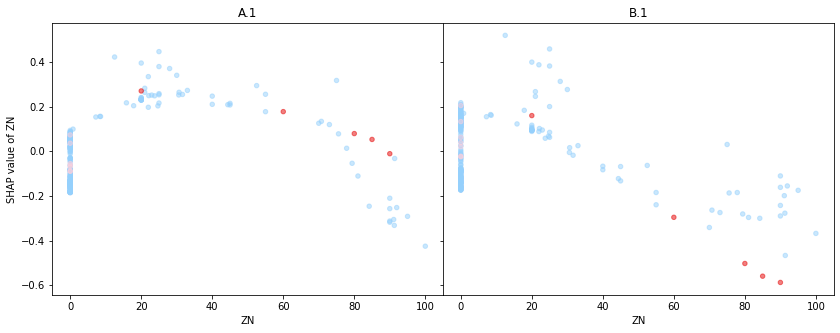

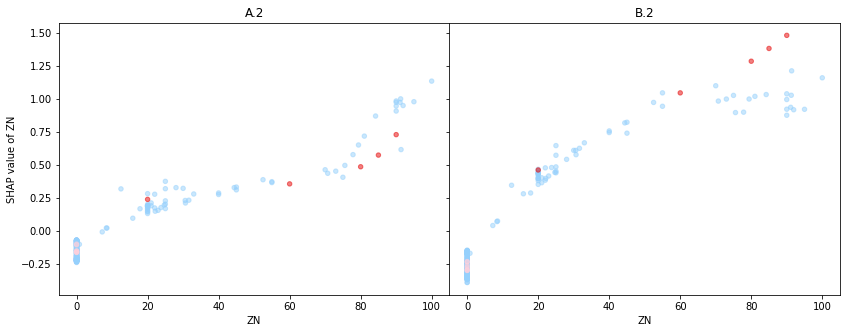

In [36]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('ZN', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

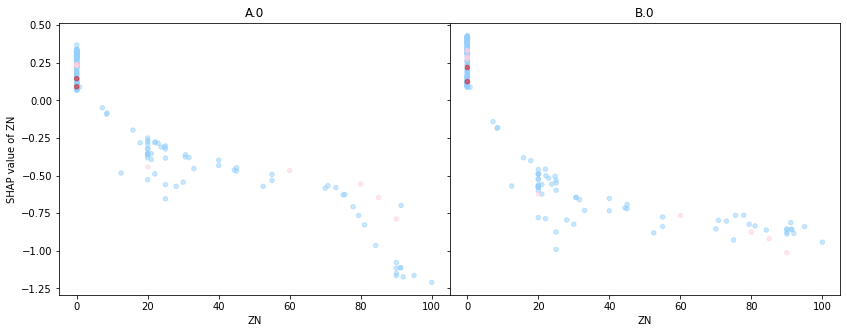

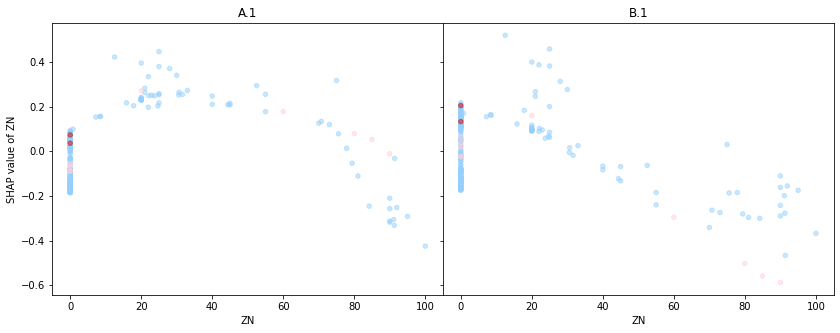

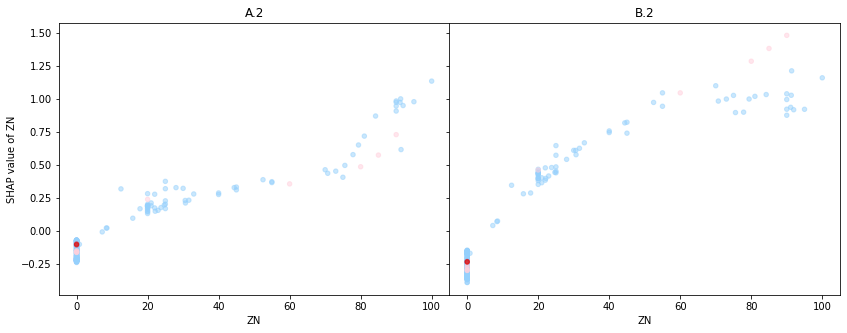

In [37]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('ZN', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

Different slopes present

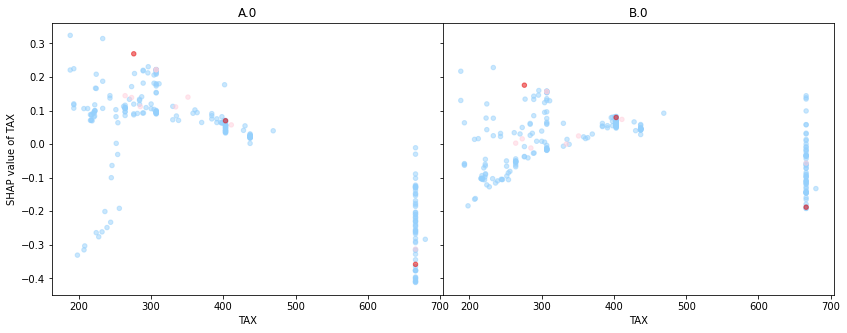

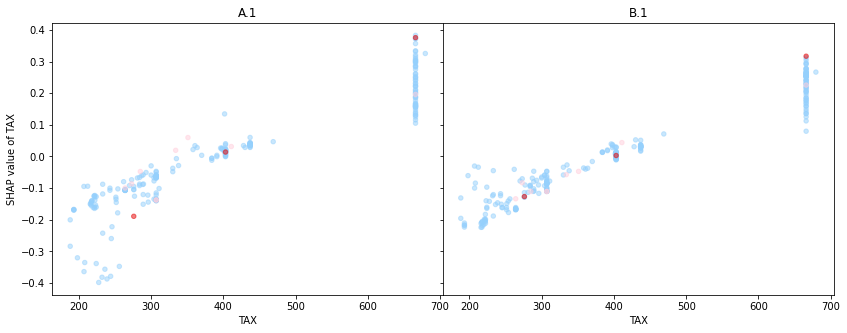

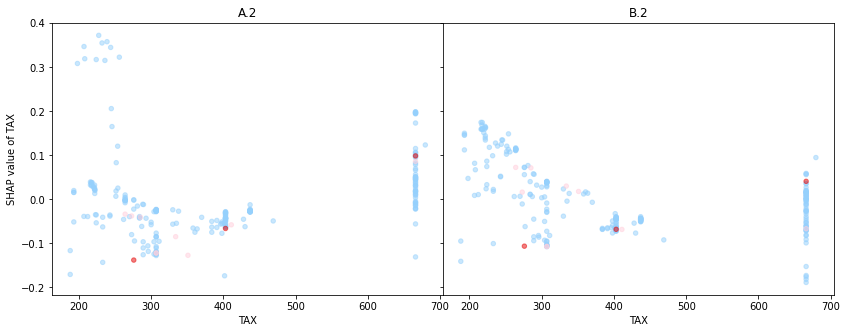

In [38]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('TAX', classes=list(classes), alpha=0.5, fill=pred_label_names == '(0, 1)')

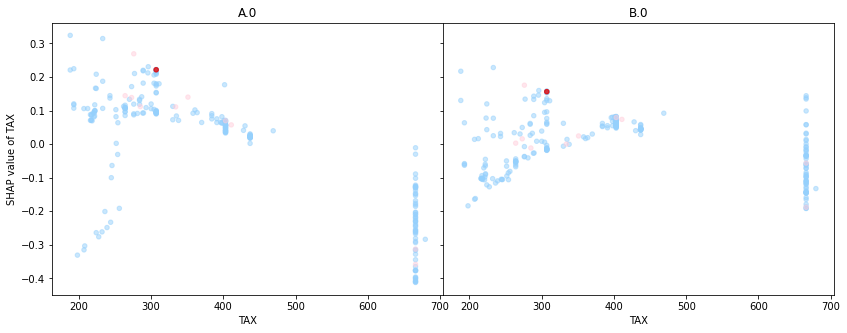

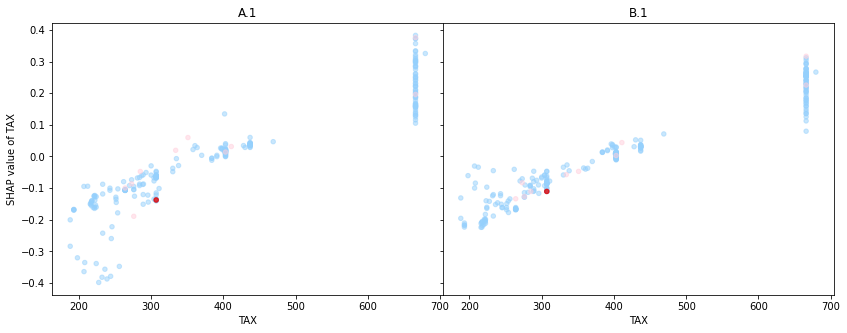

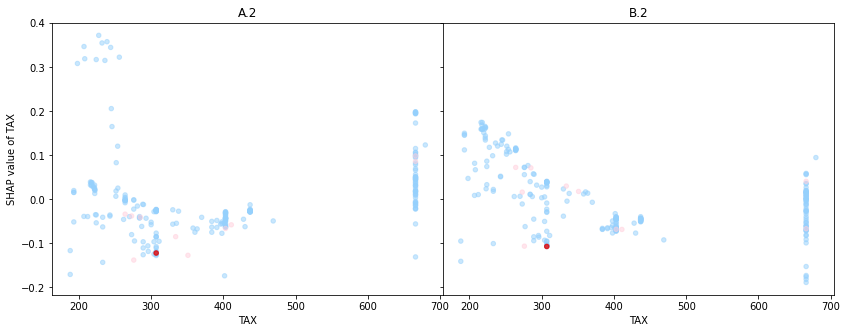

In [39]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('TAX', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 0)')

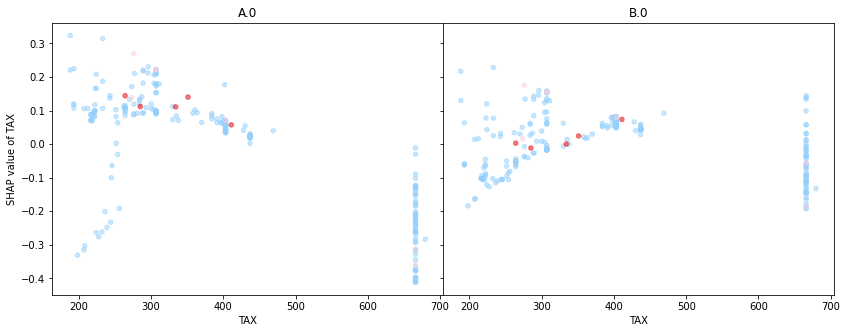

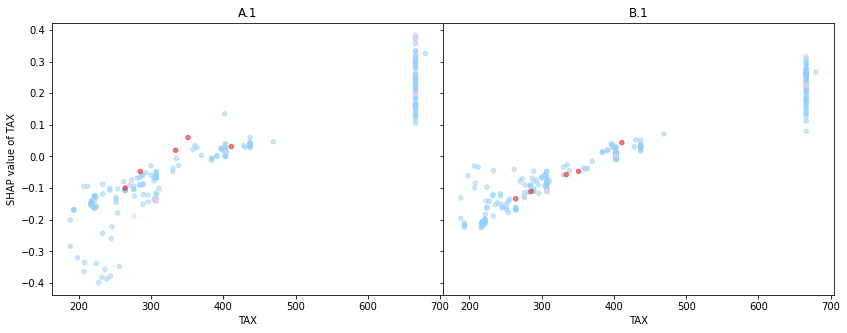

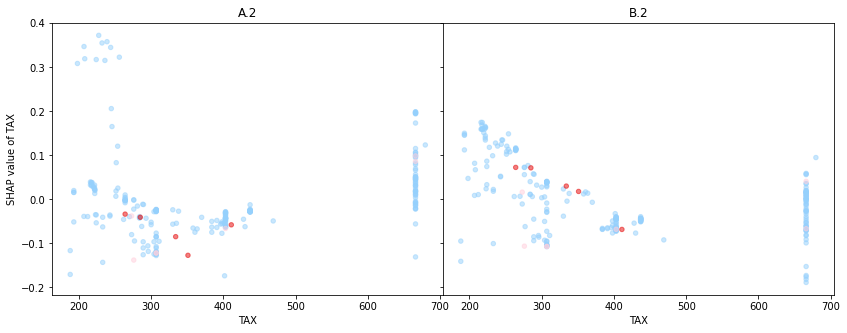

In [40]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('TAX', classes=list(classes), alpha=0.5, fill=pred_label_names == '(1, 2)')

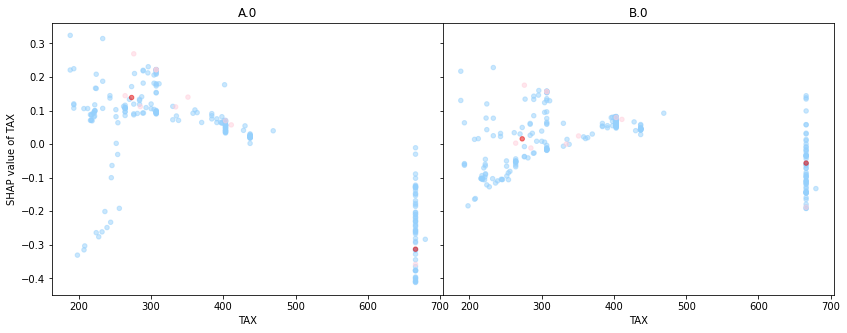

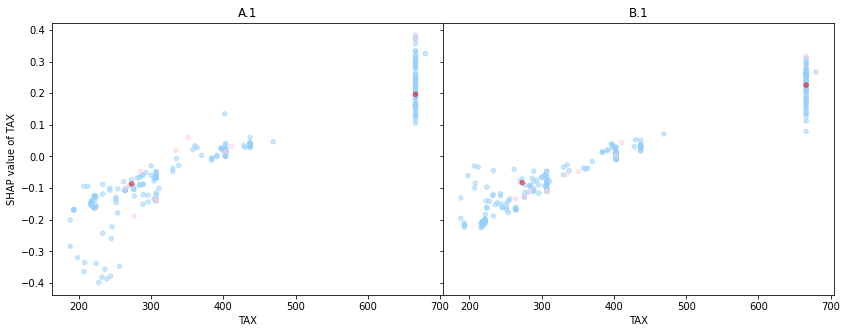

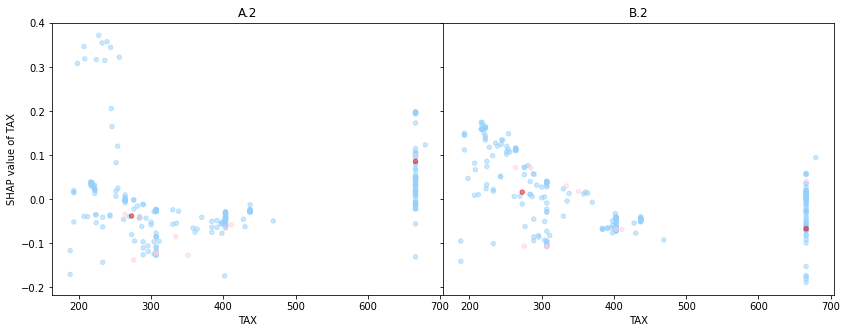

In [41]:
for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
    node.plot_feature_dependence('TAX', classes=list(classes), alpha=0.5, fill=pred_label_names == '(2, 1)')

# Comparing with Difference Classifier

## A vs. B

### (0,1)

In [112]:
with open(f'Task 3/clustering.(0, 1).pickle', 'rb') as f:
    node = pickle.load(f)

In [114]:
X = pd.DataFrame(node.data, columns=feature_names, index=node.instance_indices)

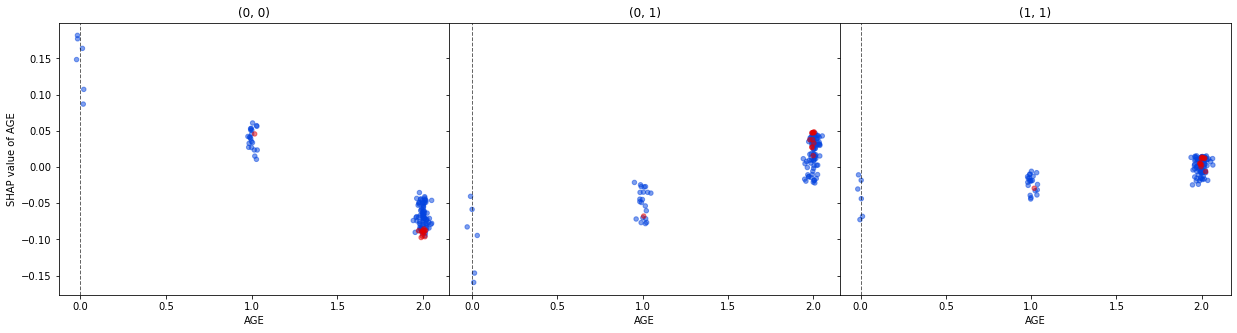

In [43]:
node.left.plot_feature_dependence('AGE', alpha=0.5)

while for the other part $(1,1)$ and $(0,1)$ is decreasing linearly with AGE

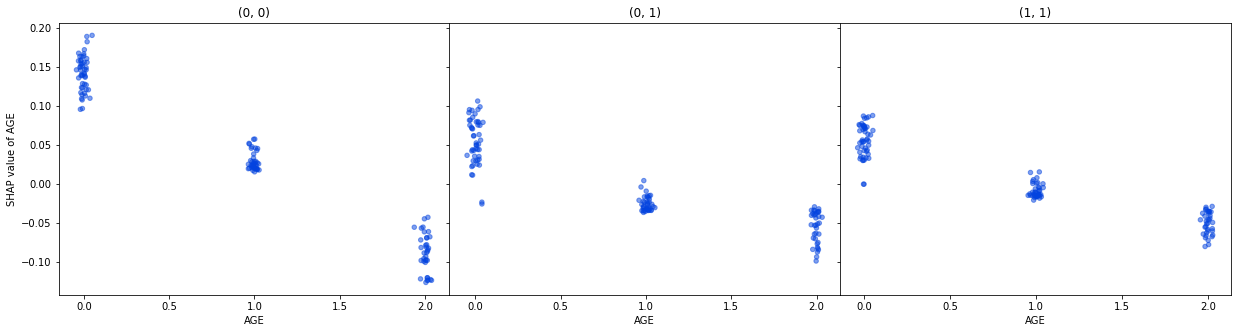

In [44]:
node.right.plot_feature_dependence('AGE', alpha=0.5)

The two parts discriminate nicely at approx. LSTAT=10. (dark: left child node which contains the instances classified $(0,1)$)

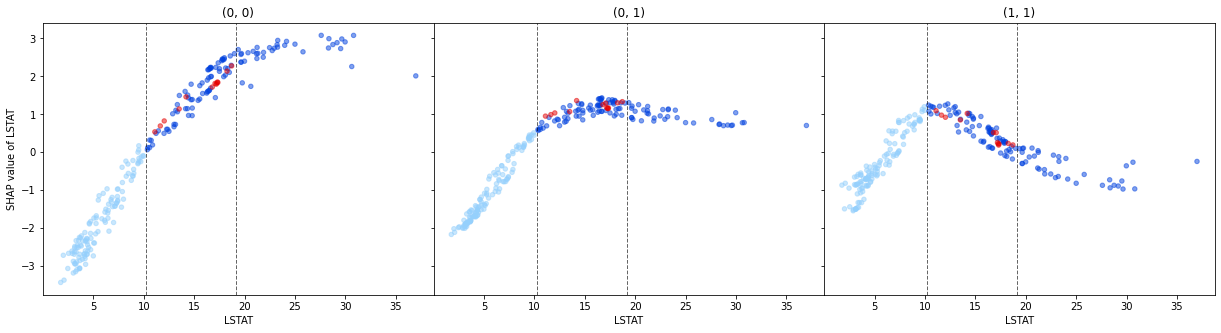

In [45]:
node.root.plot_feature_dependence('LSTAT', alpha=0.5, focus=node.left)

In [106]:
node = node.root.get('LR')

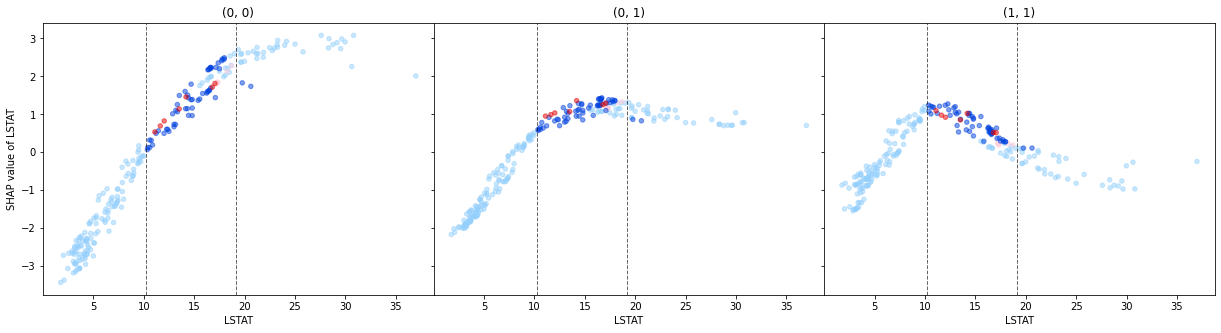

In [107]:
node.root.plot_feature_dependence('LSTAT', alpha=0.5, focus=node)

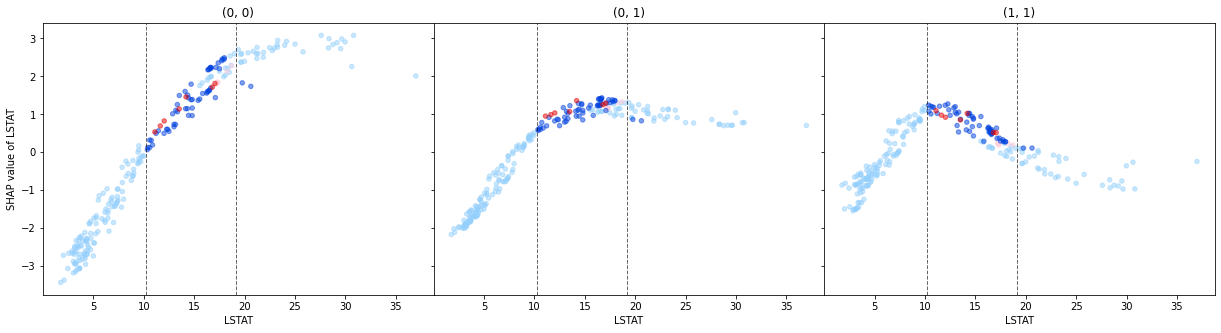

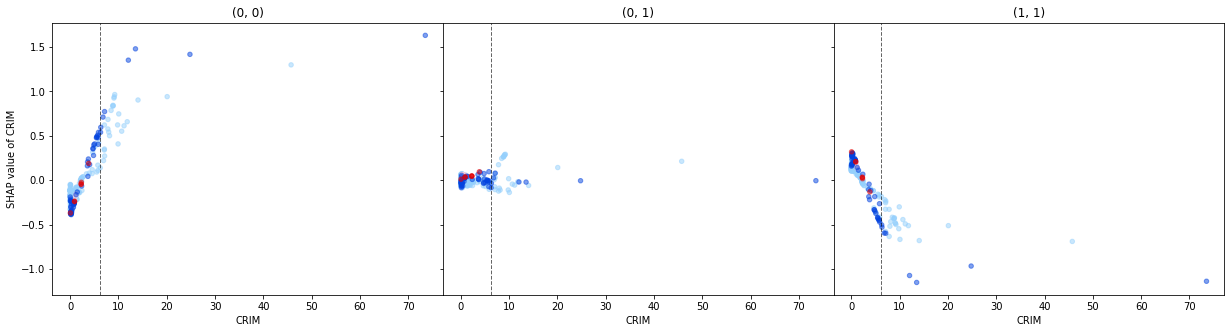

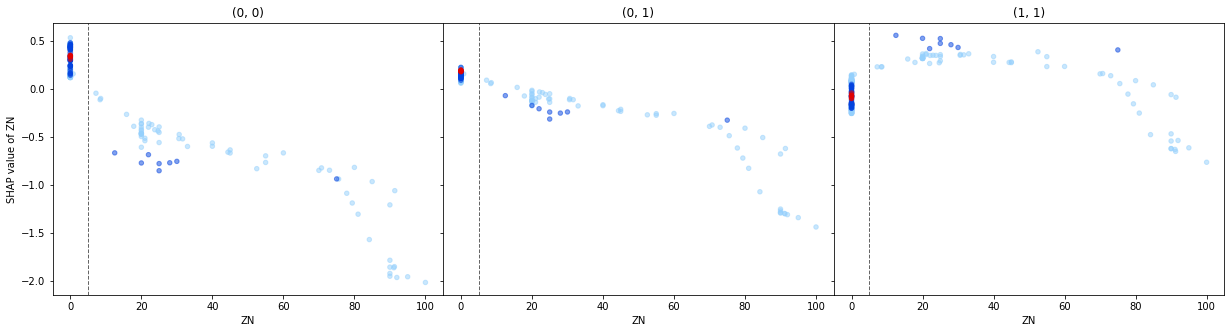

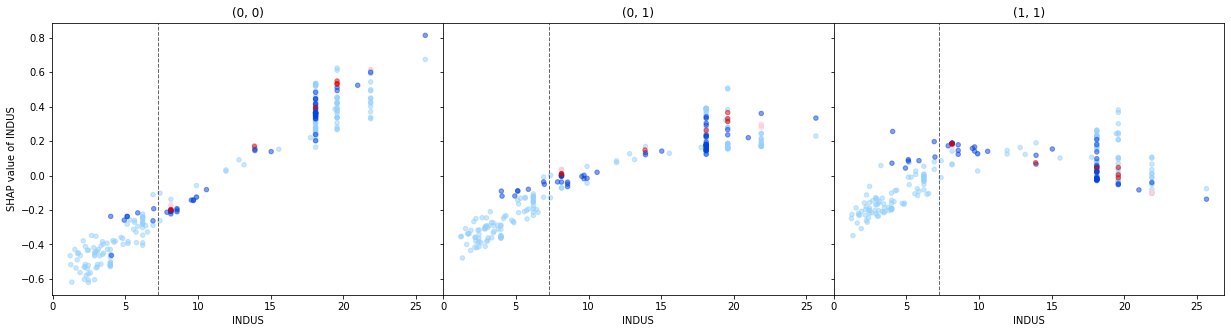

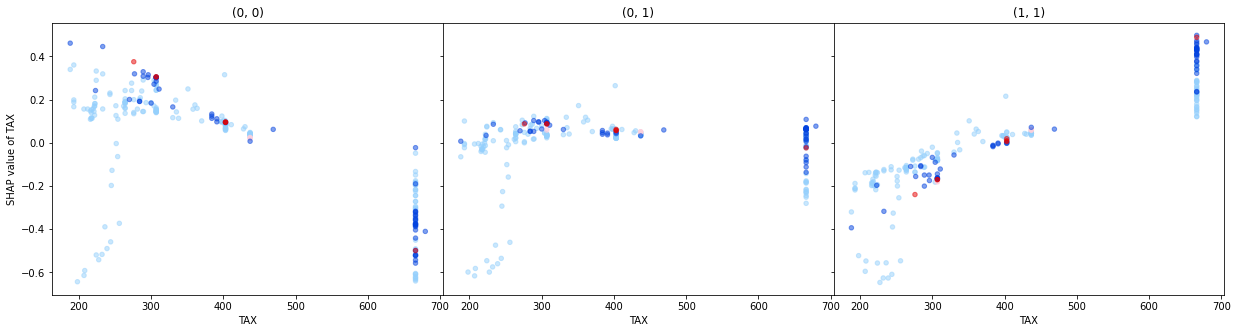

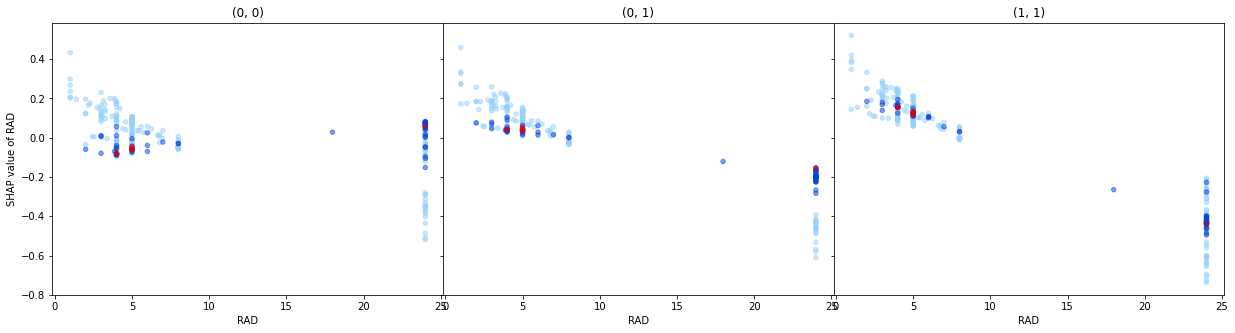

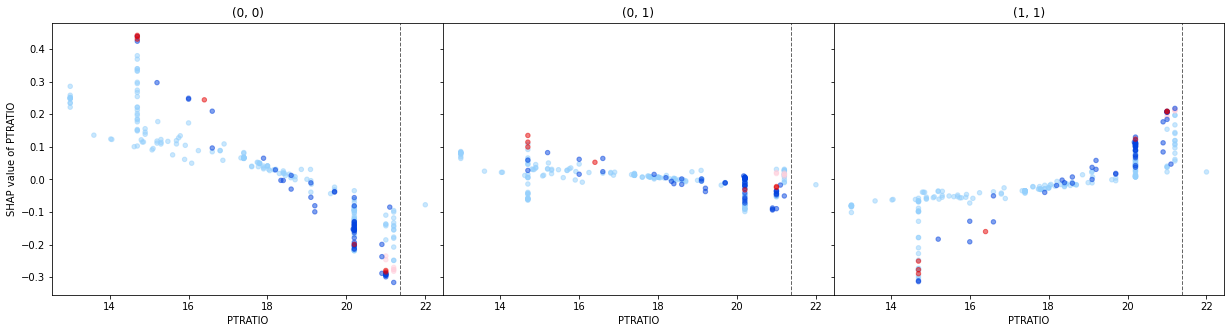

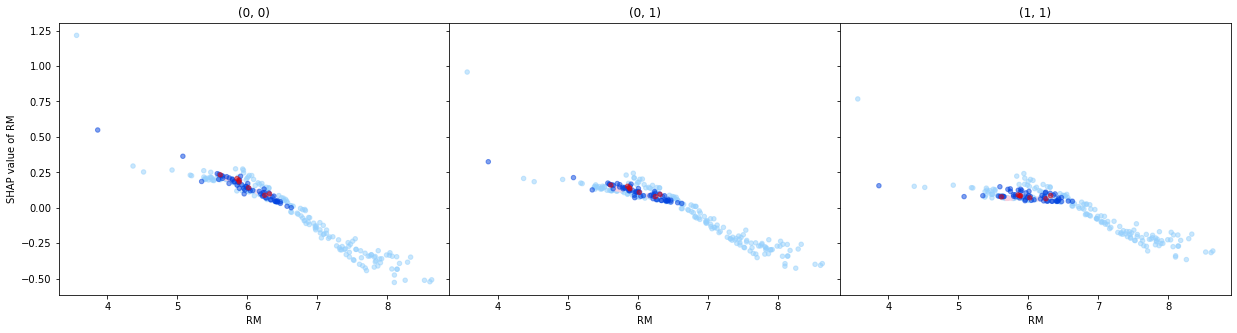

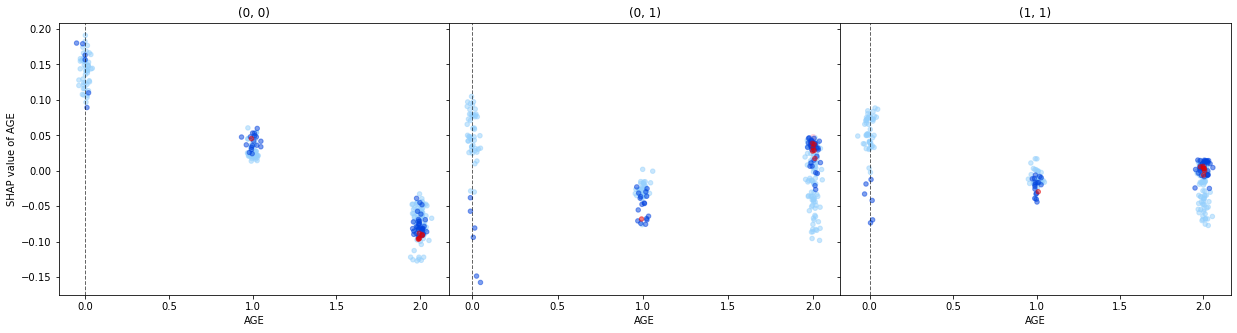

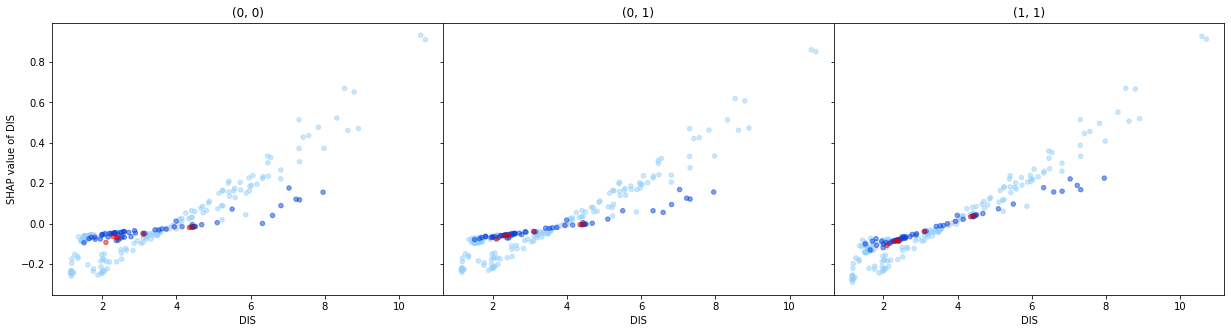

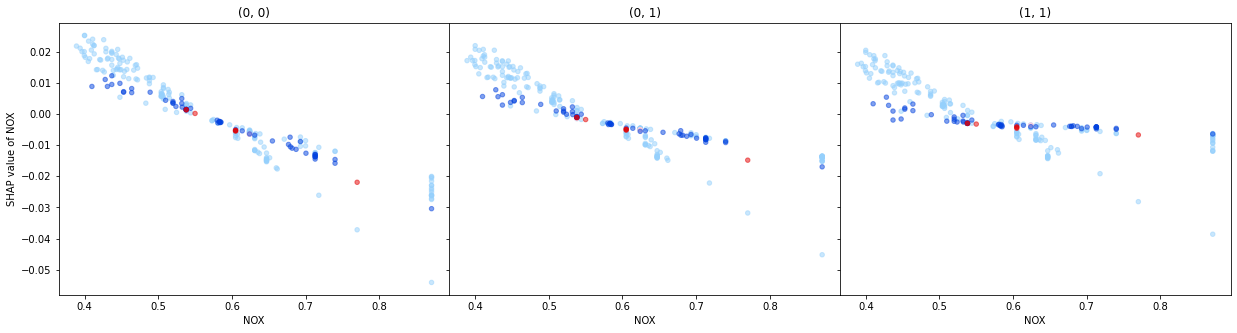

In [108]:
for feature in node.features_ordered:
    node.root.plot_feature_dependence(feature, alpha=0.5, focus=node)

In [109]:
node = node.root.get('LLRR')

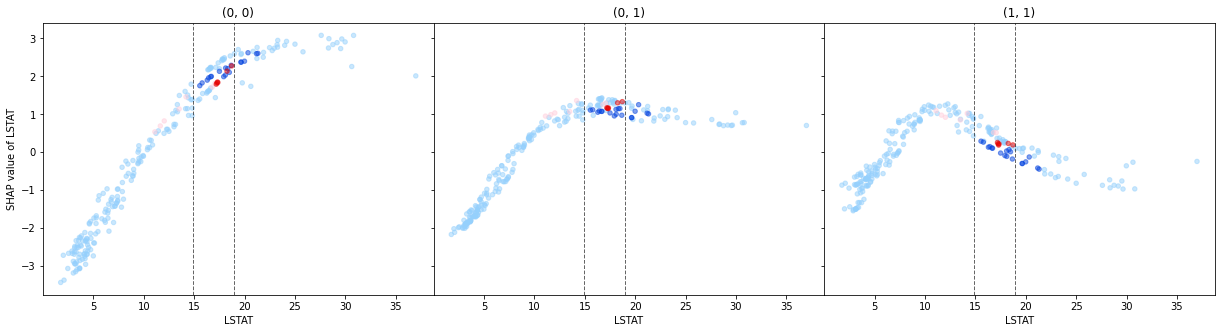

In [110]:
node.root.plot_feature_dependence('LSTAT', alpha=0.5, focus=node)

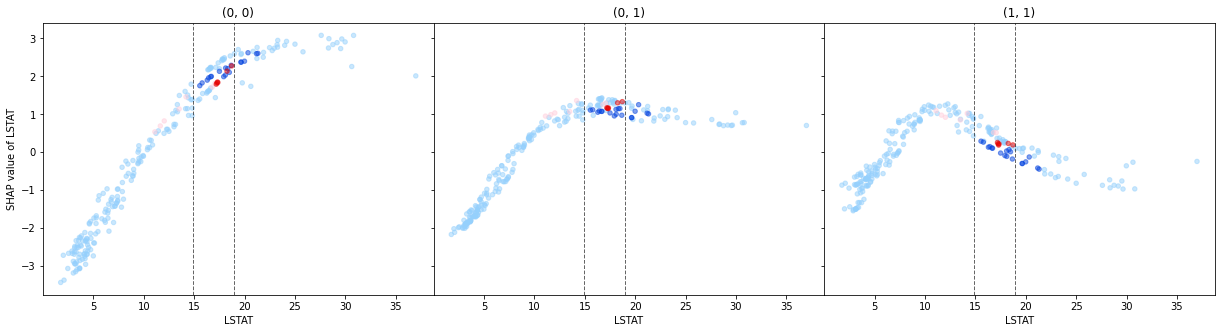

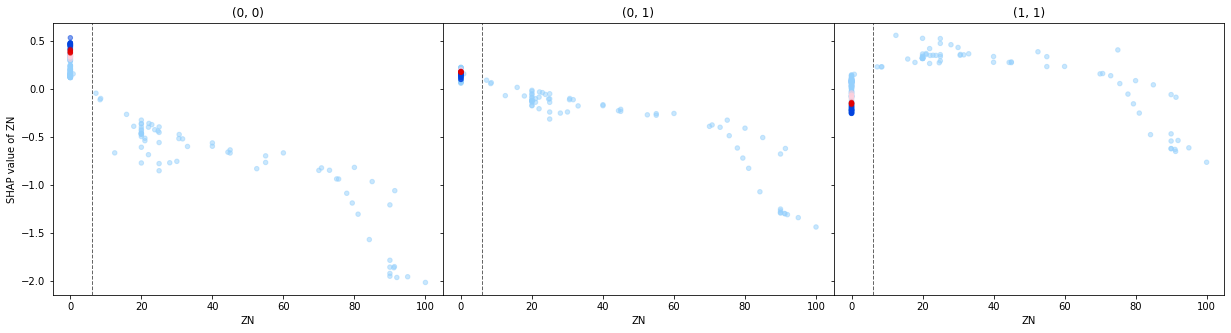

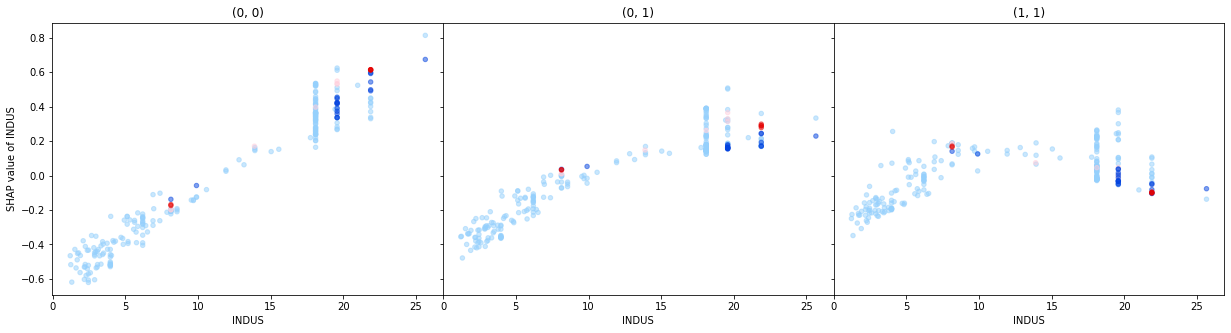

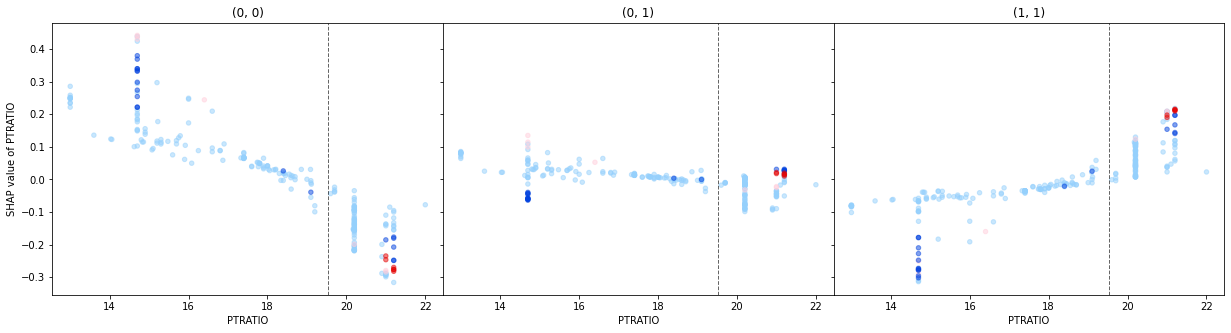

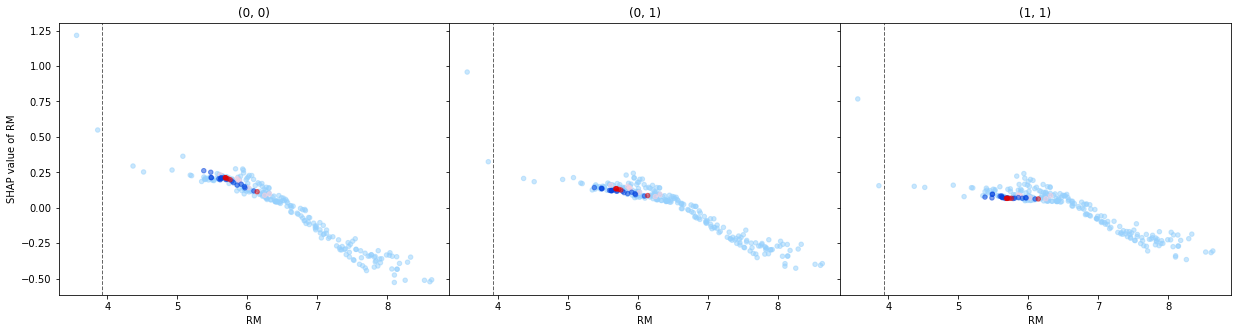

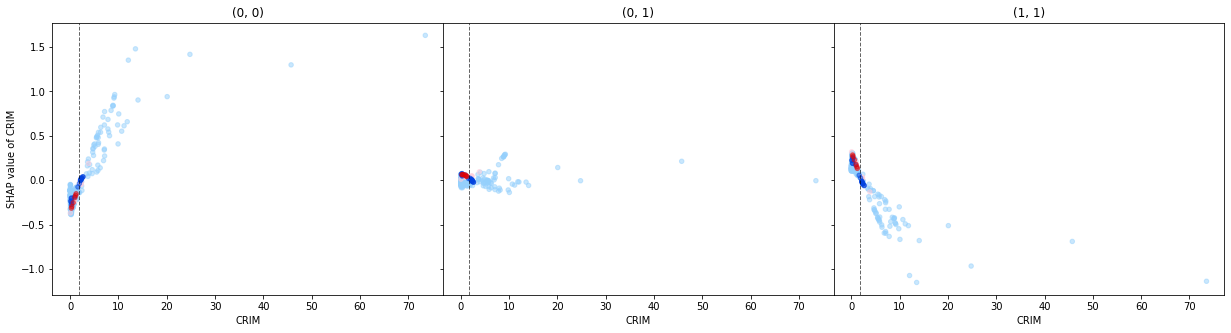

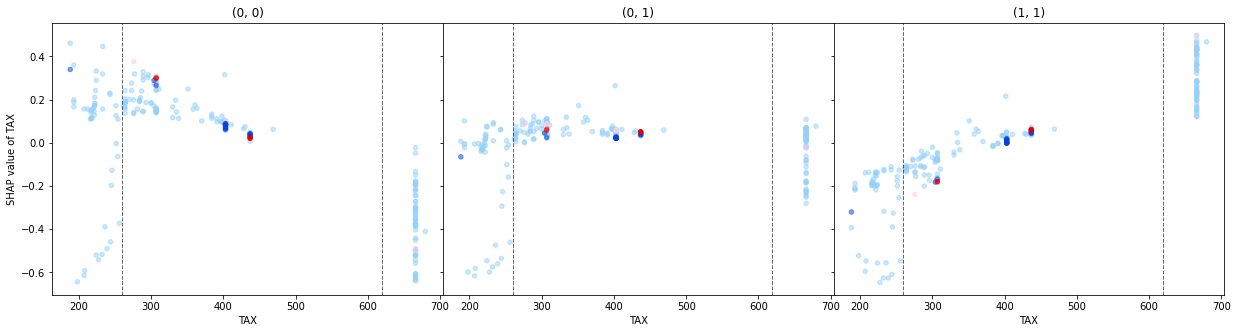

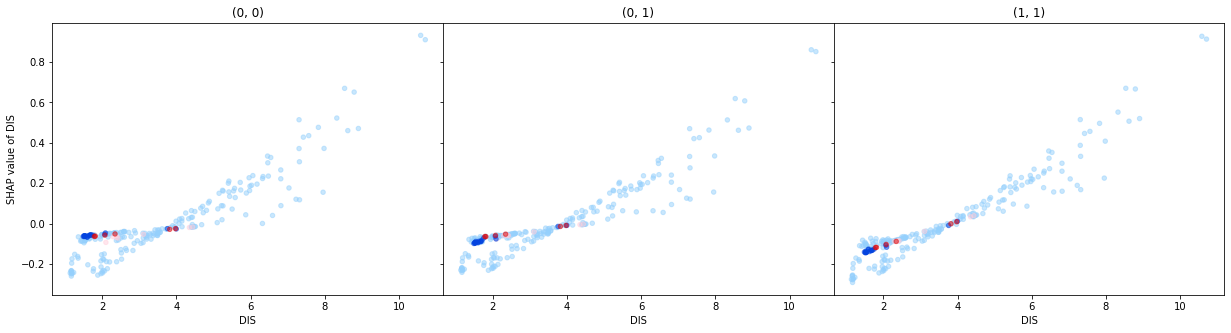

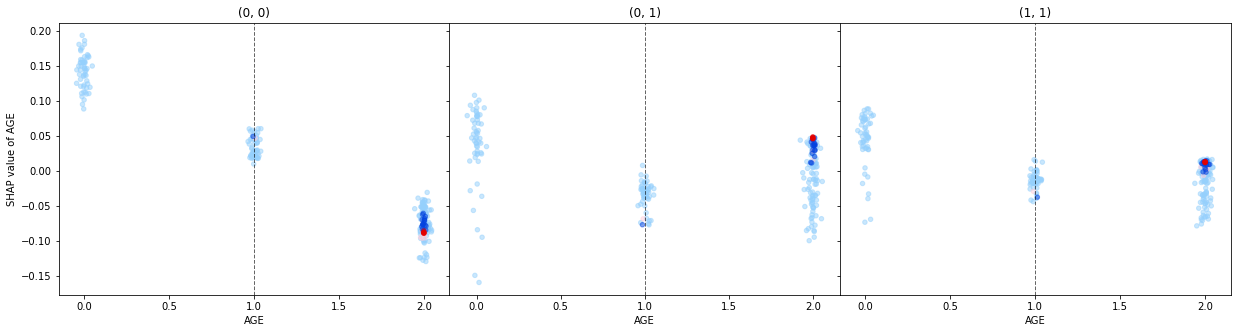

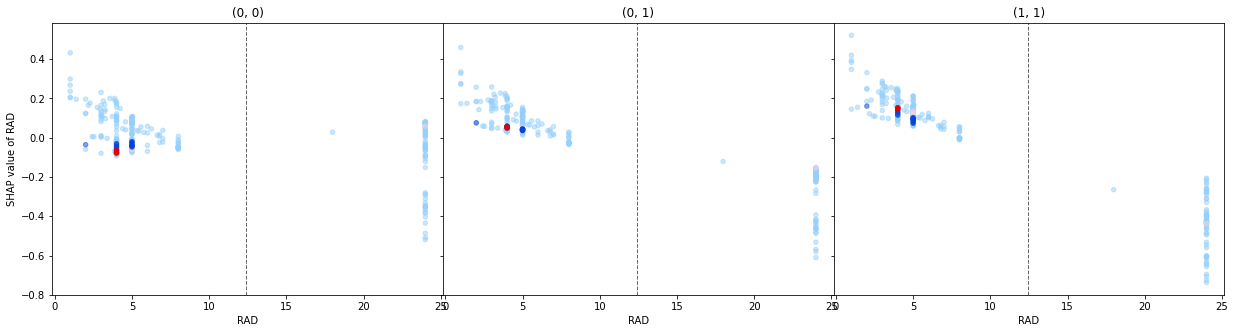

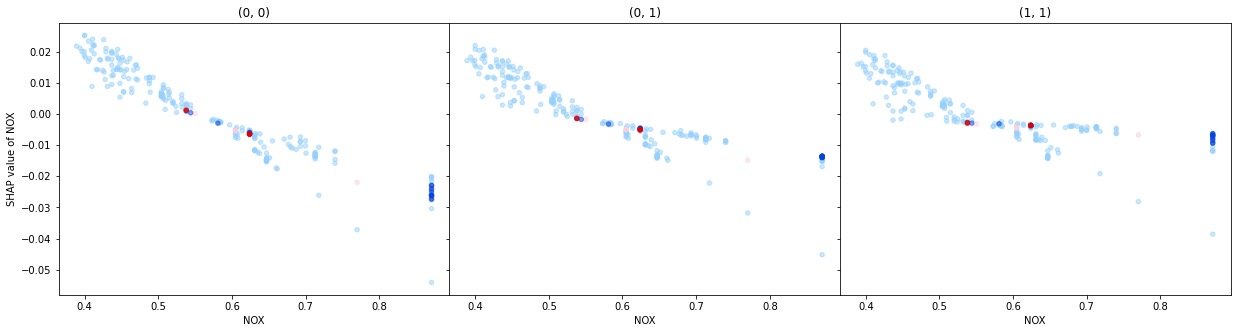

In [111]:
for feature in node.features_ordered:
    node.root.plot_feature_dependence(feature, alpha=0.5, focus=node)

### (1,2)

In [49]:
with open(f'Task 3/clustering.(1, 2).pickle', 'rb') as f:
    node = pickle.load(f)

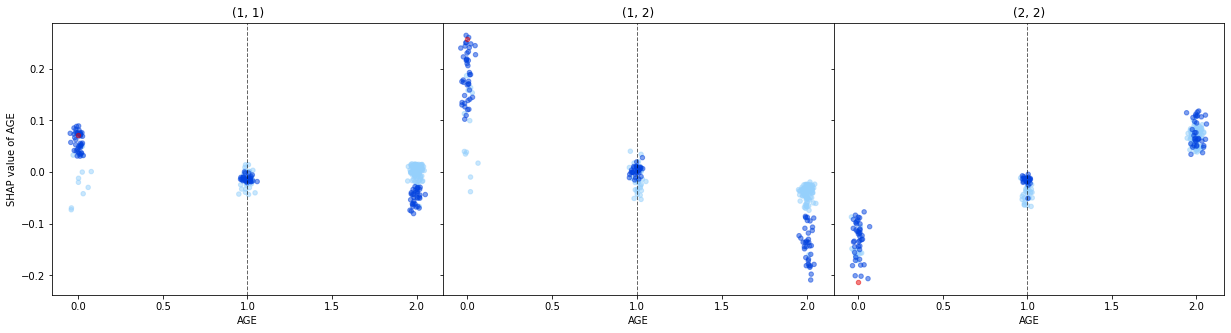

In [57]:
node.plot_feature_dependence('AGE', focus=node.get('L'), alpha=0.5)

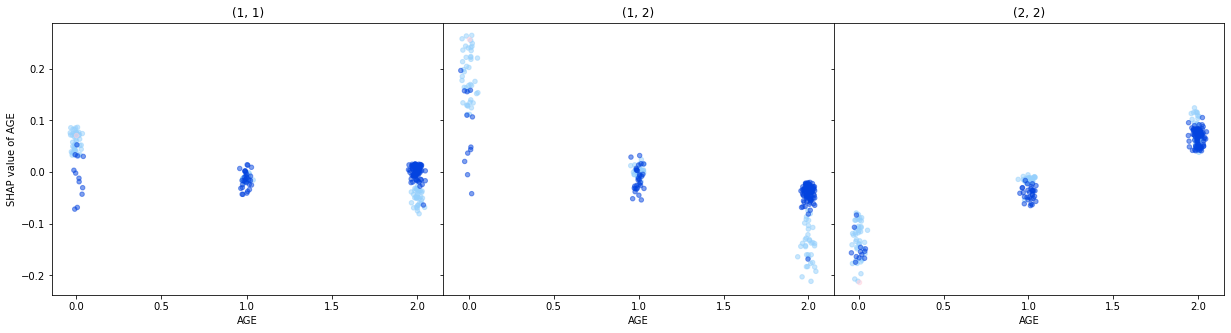

In [54]:
node.plot_feature_dependence('AGE', focus=node.get('R'), alpha=0.5)

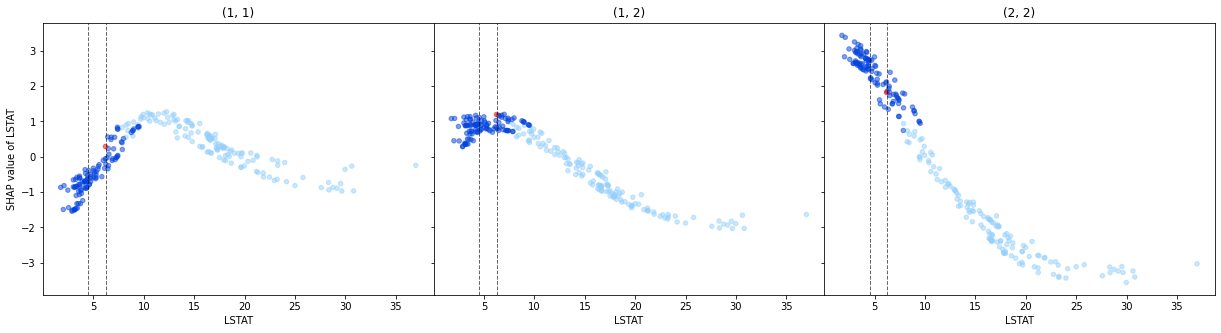

In [55]:
node.root.plot_feature_dependence('LSTAT', alpha=0.5, focus=node.left)

### (2,1)

In [50]:
with open(f'Task 3/clustering.(2, 1).pickle', 'rb') as f:
    node = pickle.load(f)

## A vs. C

### (0,1)

In [115]:
with open(f'Task 4/clustering.(0, 1).pickle', 'rb') as f:
    node = pickle.load(f)

In [116]:
X = pd.DataFrame(node.data, columns=feature_names, index=node.instance_indices)

For part of the instances, $(1,1)$ is constant and $(0,1)$ increasing linearly with AGE

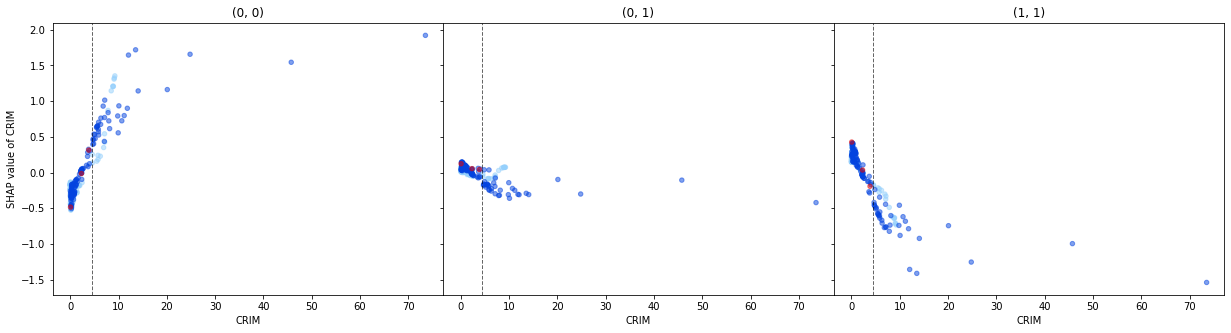

In [76]:
node.plot_feature_dependence('CRIM', alpha=0.5, focus=node.get('L'))

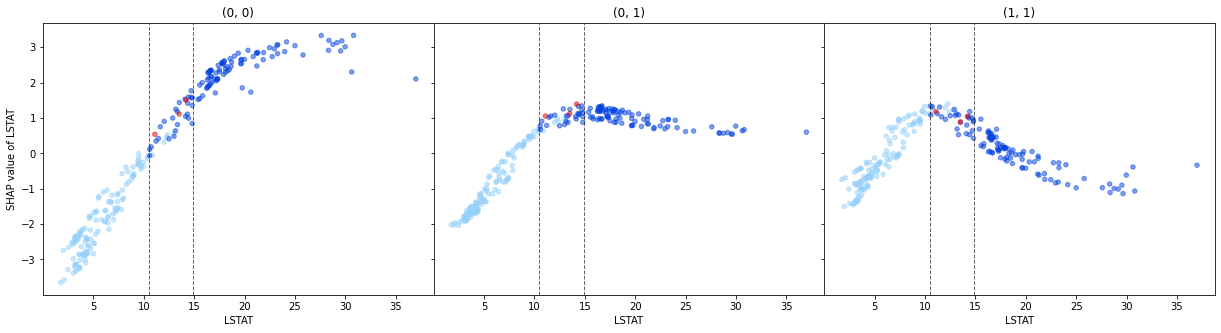

In [75]:
node.plot_feature_dependence('LSTAT', alpha=0.5, focus=node.get('L'))

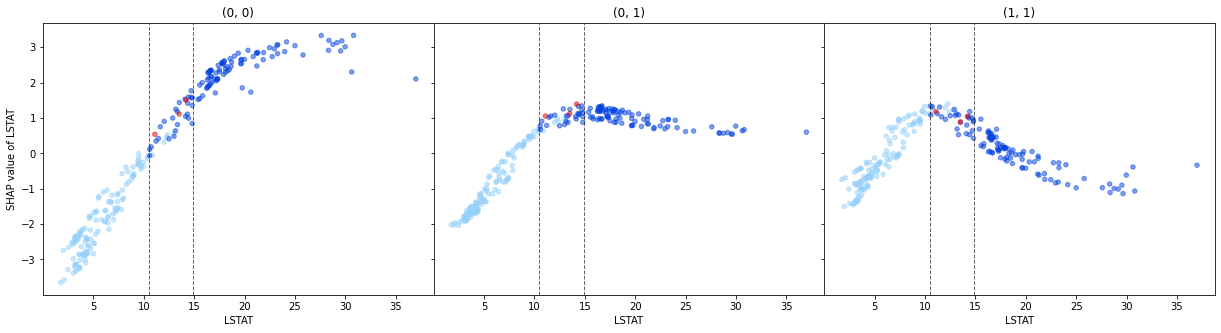

In [75]:
node.plot_feature_dependence('LSTAT', alpha=0.5, focus=node.get('L'))

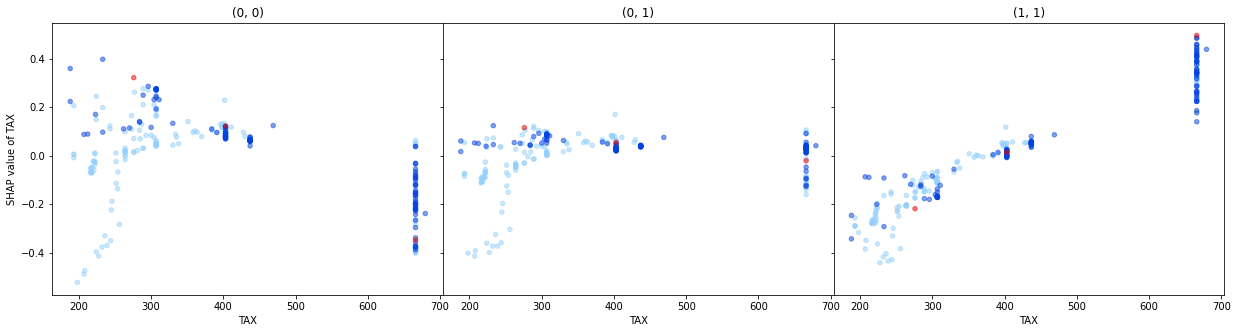

In [78]:
node.plot_feature_dependence('TAX', alpha=0.5, focus=node.get('L'))

### (1,0)

In [60]:
with open(f'Task 4/clustering.(1, 0).pickle', 'rb') as f:
    node = pickle.load(f)

### (1,2)

In [67]:
with open(f'Task 4/clustering.(1, 2).pickle', 'rb') as f:
    node = pickle.load(f)

### (2,1)

In [68]:
with open(f'Task 4/clustering.(2, 1).pickle', 'rb') as f:
    node = pickle.load(f)